---
#PARTE II: ANÁLISIS TÉCNICO
---

Realizar análisis técnico completo de tu empresa asignada desarrollando una estrategia de trading fundamentada.

---


##Auxiliares

###Modulos

In [1]:
"""
Módulo de Utilidades para Obtención y Limpieza de Datos
Trabajo Práctico - Análisis Integral de Inversiones

Funciones principales:
- obtener_datos_historicos(): Descarga datos de yfinance
- limpiar_datos(): Limpieza y validación de datos
- calcular_retornos(): Cálculo de retornos logarítmicos
- detectar_outliers(): Identificación de valores atípicos
- validar_datos(): Validación de calidad de datos
"""

import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import warnings
from scipy import stats

def obtener_datos_historicos(tickers, periodo="5y", inicio=None, fin=None):
    """
    Obtiene datos históricos para una lista de tickers usando yfinance

    Parámetros:
    -----------
    tickers : list o str
        Lista de símbolos de acciones o ticker individual
    periodo : str, opcional
        Período de datos ("5y", "2y", "1y", "6mo", etc.)
    inicio : str, opcional
        Fecha de inicio en formato 'YYYY-MM-DD'
    fin : str, opcional
        Fecha de fin en formato 'YYYY-MM-DD'

    Retorna:
    --------
    pandas.DataFrame : Precios de cierre ajustados
    """

    print(f"📥 Descargando datos históricos...")
    print(f"📊 Tickers: {tickers}")
    print(f"📅 Período: {periodo}")

    # Convertir a lista si es un string
    if isinstance(tickers, str):
        tickers = [tickers]

    try:
        # Descargar datos
        if inicio and fin:
            data = yf.download(tickers, start=inicio, end=fin, progress=False)
        else:
            data = yf.download(tickers, period=periodo, progress=False)

        # Extraer precios de cierre ajustados
        if 'Adj Close' in data.columns:
            precios = data['Adj Close']
        else:
            precios = data

        # Si es una sola acción, convertir a DataFrame
        if isinstance(precios, pd.Series):
            precios = precios.to_frame(name=tickers[0])

        # Validar datos obtenidos
        if precios.empty:
            raise ValueError("No se obtuvieron datos para los tickers especificados")

        print(f"✅ Datos obtenidos exitosamente:")
        print(f"   📈 {precios.shape[0]} observaciones")
        print(f"   🏢 {precios.shape[1]} activos")
        print(f"   📅 Período: {precios.index[0].date()} a {precios.index[-1].date()}")

        return precios

    except Exception as e:
        print(f"❌ Error obteniendo datos: {str(e)}")
        raise

def calcular_retornos(precios, metodo='logaritmico'):
    """
    Calcula retornos de los precios

    Parámetros:
    -----------
    precios : pandas.DataFrame
        DataFrame con precios de activos
    metodo : str, opcional
        Método de cálculo: 'logaritmico' (default) o 'simple'

    Retorna:
    --------
    pandas.DataFrame : Retornos calculados
    """

    print(f"📊 Calculando retornos {metodo}s...")

    if metodo == 'logaritmico':
        retornos = np.log(precios / precios.shift(1))
    elif metodo == 'simple':
        retornos = precios.pct_change()
    else:
        raise ValueError("Método debe ser 'logaritmico' o 'simple'")

    # Eliminar primera fila (NaN)
    retornos = retornos.dropna()

    print(f"✅ Retornos calculados: {retornos.shape[0]} observaciones")

    return retornos

def detectar_outliers(data, metodo='zscore', umbral=3):
    """
    Detecta outliers en los datos

    Parámetros:
    -----------
    data : pandas.DataFrame o pandas.Series
        Datos a analizar
    metodo : str, opcional
        Método de detección: 'zscore' (default) o 'iqr'
    umbral : float, opcional
        Umbral para considerar outlier (default: 3 para zscore, 1.5 para IQR)

    Retorna:
    --------
    pandas.DataFrame : Matriz booleana indicando outliers
    """

    print(f"🔍 Detectando outliers usando método: {metodo}")

    if isinstance(data, pd.Series):
        data = data.to_frame()

    outliers = pd.DataFrame(False, index=data.index, columns=data.columns)

    for col in data.columns:
        serie = data[col].dropna()

        if metodo == 'zscore':
            z_scores = np.abs(stats.zscore(serie))
            outliers.loc[serie.index, col] = z_scores > umbral

        elif metodo == 'iqr':
            Q1 = serie.quantile(0.25)
            Q3 = serie.quantile(0.75)
            IQR = Q3 - Q1
            limite_inferior = Q1 - umbral * IQR
            limite_superior = Q3 + umbral * IQR
            outliers.loc[serie.index, col] = (serie < limite_inferior) | (serie > limite_superior)

    num_outliers = outliers.sum().sum()
    print(f"⚠️  Outliers detectados: {num_outliers}")

    return outliers

def limpiar_datos(df, metodo_faltantes='ffill', remover_outliers=False, umbral_outliers=3):
    """
    Limpia y prepara los datos para análisis

    TAREA CRÍTICA PARA ESTUDIANTES:
    Deben justificar su metodología para manejar datos faltantes y outliers

    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame con datos a limpiar
    metodo_faltantes : str, opcional
        Método para datos faltantes: 'ffill', 'bfill', 'interpolate', 'drop'
    remover_outliers : bool, opcional
        Si remover outliers detectados
    umbral_outliers : float, opcional
        Umbral para detección de outliers

    Retorna:
    --------
    pandas.DataFrame : Datos limpios
    dict : Reporte de limpieza
    """

    print("🧹 === INICIANDO LIMPIEZA DE DATOS ===")

    # Crear copia para no modificar original
    df_limpio = df.copy()

    # Reporte inicial
    reporte = {
        'filas_originales': len(df),
        'columnas_originales': len(df.columns),
        'datos_faltantes_original': df.isnull().sum().to_dict(),
        'outliers_detectados': {},
        'metodo_faltantes': metodo_faltantes,
        'remover_outliers': remover_outliers
    }

    print(f"📊 Datos originales: {df.shape}")
    print(f"📉 Datos faltantes por columna:")
    for col, faltantes in reporte['datos_faltantes_original'].items():
        if faltantes > 0:
            print(f"   {col}: {faltantes} ({faltantes/len(df)*100:.1f}%)")

    # 1. Manejo de datos faltantes
    if df.isnull().any().any():
        print(f"🔧 Aplicando método '{metodo_faltantes}' para datos faltantes...")

        if metodo_faltantes == 'ffill':
            df_limpio = df_limpio.fillna(method='ffill')
        elif metodo_faltantes == 'bfill':
            df_limpio = df_limpio.fillna(method='bfill')
        elif metodo_faltantes == 'interpolate':
            df_limpio = df_limpio.interpolate()
        elif metodo_faltantes == 'drop':
            df_limpio = df_limpio.dropna()

        # Verificar si quedan datos faltantes
        faltantes_restantes = df_limpio.isnull().sum().sum()
        if faltantes_restantes > 0:
            print(f"⚠️  Aún quedan {faltantes_restantes} datos faltantes después de la limpieza")

    # 2. Detección y manejo de outliers
    if remover_outliers:
        print("🔍 Detectando outliers...")
        outliers = detectar_outliers(df_limpio, umbral=umbral_outliers)

        # Contar outliers por columna
        for col in outliers.columns:
            num_outliers = outliers[col].sum()
            reporte['outliers_detectados'][col] = num_outliers

            if num_outliers > 0:
                print(f"   {col}: {num_outliers} outliers")

                # TODO: Los estudiantes deben decidir cómo manejar outliers
                # Opciones: eliminar, winsorize, transformar, etc.
                # Por ahora solo reportamos

        print("📝 TAREA PARA ESTUDIANTES:")
        print("   - Analizar patrones en datos faltantes")
        print("   - Justificar método de imputación elegido")
        print("   - Decidir qué hacer con outliers detectados")
        print("   - Documentar todas las decisiones tomadas")

    # 3. Validaciones finales
    print("✅ Validaciones finales:")

    # Verificar fechas duplicadas
    fechas_duplicadas = df_limpio.index.duplicated().sum()
    if fechas_duplicadas > 0:
        print(f"⚠️  {fechas_duplicadas} fechas duplicadas encontradas")
        df_limpio = df_limpio[~df_limpio.index.duplicated(keep='first')]

    # Verificar orden cronológico
    if not df_limpio.index.is_monotonic_increasing:
        print("📅 Ordenando datos cronológicamente...")
        df_limpio = df_limpio.sort_index()

    # Estadísticas finales
    reporte.update({
        'filas_finales': len(df_limpio),
        'datos_faltantes_final': df_limpio.isnull().sum().to_dict(),
        'periodo_final': f"{df_limpio.index[0].date()} a {df_limpio.index[-1].date()}"
    })

    print(f"✅ Limpieza completada:")
    print(f"   📊 Datos finales: {df_limpio.shape}")
    print(f"   📅 Período: {reporte['periodo_final']}")

    return df_limpio, reporte

def validar_datos(df, nombre_activo="Activo"):
    """
    Valida la calidad de los datos financieros

    Parámetros:
    -----------
    df : pandas.DataFrame
        Datos a validar
    nombre_activo : str, opcional
        Nombre para identificar el activo en reportes

    Retorna:
    --------
    dict : Reporte de validación
    """

    print(f"🔍 === VALIDANDO CALIDAD DE DATOS: {nombre_activo} ===")

    validaciones = {
        'activo': nombre_activo,
        'periodo': f"{df.index[0].date()} a {df.index[-1].date()}",
        'observaciones': len(df),
        'problemas_detectados': [],
        'warnings': [],
        'stats_basicas': {}
    }

    for col in df.columns:
        serie = df[col]

        # Estadísticas básicas
        validaciones['stats_basicas'][col] = {
            'min': serie.min(),
            'max': serie.max(),
            'mean': serie.mean(),
            'std': serie.std(),
            'valores_cero': (serie == 0).sum(),
            'valores_negativos': (serie < 0).sum() if serie.min() < 0 else 0
        }

        # Validaciones específicas

        # 1. Valores negativos en precios (si es columna de precios)
        if 'price' in col.lower() or 'precio' in col.lower():
            if serie.min() <= 0:
                validaciones['problemas_detectados'].append(
                    f"{col}: Contiene precios negativos o cero"
                )

        # 2. Volatilidad extrema
        if len(serie) > 1:
            retornos = serie.pct_change().dropna()
            if retornos.std() > 0.1:  # 10% diario
                validaciones['warnings'].append(
                    f"{col}: Volatilidad muy alta ({retornos.std()*100:.1f}% diario)"
                )

        # 3. Valores constantes
        if serie.nunique() == 1:
            validaciones['problemas_detectados'].append(
                f"{col}: Todos los valores son iguales ({serie.iloc[0]})"
            )

        # 4. Saltos extremos
        if len(serie) > 1:
            cambios = serie.pct_change().dropna()
            cambios_extremos = (cambios.abs() > 0.5).sum()  # >50% en un día
            if cambios_extremos > 0:
                validaciones['warnings'].append(
                    f"{col}: {cambios_extremos} cambios diarios >50%"
                )

    # Mostrar resultados
    print(f"📊 Período analizado: {validaciones['periodo']}")
    print(f"📈 Observaciones: {validaciones['observaciones']}")

    if validaciones['problemas_detectados']:
        print("❌ Problemas detectados:")
        for problema in validaciones['problemas_detectados']:
            print(f"   • {problema}")

    if validaciones['warnings']:
        print("⚠️  Advertencias:")
        for warning in validaciones['warnings']:
            print(f"   • {warning}")

    if not validaciones['problemas_detectados'] and not validaciones['warnings']:
        print("✅ No se detectaron problemas en los datos")

    return validaciones

def obtener_info_mercado(ticker):
    """
    Obtiene información adicional sobre un ticker

    Parámetros:
    -----------
    ticker : str
        Símbolo del activo

    Retorna:
    --------
    dict : Información del ticker
    """

    try:
        stock = yf.Ticker(ticker)
        info = stock.info

        return {
            'nombre': info.get('longName', ticker),
            'sector': info.get('sector', 'N/A'),
            'industria': info.get('industry', 'N/A'),
            'pais': info.get('country', 'N/A'),
            'moneda': info.get('currency', 'N/A'),
            'market_cap': info.get('marketCap'),
            'descripcion': info.get('longBusinessSummary', 'N/A')[:200] + '...'
        }

    except Exception as e:
        print(f"⚠️  No se pudo obtener información para {ticker}: {e}")
        return {'nombre': ticker, 'error': str(e)}

# Ejemplo de uso y testing
if __name__ == "__main__":
    print("🧪 Ejecutando tests del módulo data_utils...")

    # Test básico
    try:
        # Obtener datos de Apple
        datos = obtener_datos_historicos(['AAPL'], periodo='1y')

        # Limpiar datos
        datos_limpios, reporte = limpiar_datos(datos)

        # Validar
        validacion = validar_datos(datos_limpios, "AAPL")

        # Calcular retornos
        retornos = calcular_retornos(datos_limpios)

        print("✅ Todos los tests pasaron correctamente")

    except Exception as e:
        print(f"❌ Error en tests: {e}")

🧪 Ejecutando tests del módulo data_utils...
📥 Descargando datos históricos...
📊 Tickers: ['AAPL']
📅 Período: 1y


/tmp/ipython-input-3464013293.py:53: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=periodo, progress=False)


✅ Datos obtenidos exitosamente:
   📈 250 observaciones
   🏢 5 activos
   📅 Período: 2024-08-16 a 2025-08-15
🧹 === INICIANDO LIMPIEZA DE DATOS ===
📊 Datos originales: (250, 5)
📉 Datos faltantes por columna:
✅ Validaciones finales:
✅ Limpieza completada:
   📊 Datos finales: (250, 5)
   📅 Período: 2024-08-16 a 2025-08-15
🔍 === VALIDANDO CALIDAD DE DATOS: AAPL ===
❌ Error en tests: 'tuple' object has no attribute 'lower'


In [2]:
"""
Módulo de Análisis Técnico
Trabajo Práctico - Análisis Integral de Inversiones

Implementa indicadores técnicos principales para trading

Funciones principales:
- calcular_medias_moviles(): SMA, EMA, cruces
- calcular_rsi(): Relative Strength Index
- calcular_macd(): Moving Average Convergence Divergence
- calcular_bollinger_bands(): Bandas de Bollinger
- calcular_adx(): Average Directional Index
- backtest_estrategia(): Backtesting de estrategias
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

def calcular_medias_moviles(precios, ventanas=[20, 50, 200], tipo='SMA'):
    """
    Calcula medias móviles simples (SMA) o exponenciales (EMA)

    Parámetros:
    -----------
    precios : pandas.Series o pandas.DataFrame
        Precios del activo
    ventanas : list, opcional
        Lista de períodos para las medias móviles (default: [20, 50, 200])
    tipo : str, opcional
        Tipo de media: 'SMA' (simple) o 'EMA' (exponencial)

    Retorna:
    --------
    pandas.DataFrame : Precios originales con medias móviles
    """

    print(f"📊 Calculando medias móviles {tipo} con ventanas: {ventanas}")

    # Convertir a DataFrame si es Series
    if isinstance(precios, pd.Series):
        df = precios.to_frame('Precio')
    else:
        df = precios.copy()

    resultado = df.copy()

    for ventana in ventanas:
        if tipo == 'SMA':
            nombre_col = f'SMA_{ventana}'
            resultado[nombre_col] = df.iloc[:, 0].rolling(window=ventana).mean()
        elif tipo == 'EMA':
            nombre_col = f'EMA_{ventana}'
            resultado[nombre_col] = df.iloc[:, 0].ewm(span=ventana).mean()
        else:
            raise ValueError("Tipo debe ser 'SMA' o 'EMA'")

    print(f"✅ Medias móviles calculadas para {len(ventanas)} períodos")

    return resultado

def detectar_cruces_medias(datos, ma_corta, ma_larga):
    """
    Detecta cruces entre medias móviles (señales de compra/venta)

    Parámetros:
    -----------
    datos : pandas.DataFrame
        DataFrame con las medias móviles
    ma_corta : str
        Nombre de la columna de media móvil corta
    ma_larga : str
        Nombre de la columna de media móvil larga

    Retorna:
    --------
    pandas.DataFrame : Datos originales con señales de cruce
    """

    print(f"🔍 Detectando cruces entre {ma_corta} y {ma_larga}")

    resultado = datos.copy()

    # Calcular diferencia entre medias
    resultado['Diferencia'] = resultado[ma_corta] - resultado[ma_larga]

    # Detectar cruces
    resultado['Cruce'] = 0
    resultado['Señal'] = 'Hold'

    # Golden Cross (cruce alcista): MA corta cruza por encima de MA larga
    cruces_alcistas = (
        (resultado['Diferencia'] > 0) &
        (resultado['Diferencia'].shift(1) <= 0)
    )

    # Death Cross (cruce bajista): MA corta cruza por debajo de MA larga
    cruces_bajistas = (
        (resultado['Diferencia'] < 0) &
        (resultado['Diferencia'].shift(1) >= 0)
    )

    resultado.loc[cruces_alcistas, 'Cruce'] = 1
    resultado.loc[cruces_alcistas, 'Señal'] = 'Buy'

    resultado.loc[cruces_bajistas, 'Cruce'] = -1
    resultado.loc[cruces_bajistas, 'Señal'] = 'Sell'

    num_golden_cross = (resultado['Cruce'] == 1).sum()
    num_death_cross = (resultado['Cruce'] == -1).sum()

    print(f"📈 Golden Cross detectados: {num_golden_cross}")
    print(f"📉 Death Cross detectados: {num_death_cross}")

    return resultado

def calcular_rsi(precios, periodo=14):
    """
    Calcula el Relative Strength Index (RSI)

    TAREA CRÍTICA: Determinar parámetros óptimos para mercado argentino

    Parámetros:
    -----------
    precios : pandas.Series
        Serie de precios
    periodo : int, opcional
        Período para el cálculo del RSI (default: 14)

    Retorna:
    --------
    pandas.Series : Valores del RSI
    """

    print(f"📊 Calculando RSI con período {periodo}")

    # Calcular cambios diarios
    delta = precios.diff()

    # Separar ganancias y pérdidas
    ganancias = delta.where(delta > 0, 0)
    perdidas = -delta.where(delta < 0, 0)

    # Calcular promedios móviles de ganancias y pérdidas
    avg_ganancias = ganancias.rolling(window=periodo).mean()
    avg_perdidas = perdidas.rolling(window=periodo).mean()

    # Calcular RS y RSI
    rs = avg_ganancias / avg_perdidas
    rsi = 100 - (100 / (1 + rs))

    # Estadísticas del RSI
    rsi_stats = {
        'RSI_promedio': rsi.mean(),
        'RSI_min': rsi.min(),
        'RSI_max': rsi.max(),
        'Sobrecompra_70': (rsi > 70).sum(),
        'Sobreventa_30': (rsi < 30).sum()
    }

    print(f"📊 RSI calculado:")
    print(f"   Promedio: {rsi_stats['RSI_promedio']:.1f}")
    print(f"   Señales sobrecompra (>70): {rsi_stats['Sobrecompra_70']}")
    print(f"   Señales sobreventa (<30): {rsi_stats['Sobreventa_30']}")

    return rsi

def generar_señales_rsi(rsi, umbral_sobrecompra=70, umbral_sobreventa=30):
    """
    Genera señales de trading basadas en RSI

    Parámetros:
    -----------
    rsi : pandas.Series
        Valores del RSI
    umbral_sobrecompra : float, opcional
        Umbral de sobrecompra (default: 70)
    umbral_sobreventa : float, opcional
        Umbral de sobreventa (default: 30)

    Retorna:
    --------
    pandas.DataFrame : RSI con señales de trading
    """

    resultado = pd.DataFrame({'RSI': rsi})
    resultado['Señal'] = 'Hold'
    resultado['Posicion'] = 0

    # Señales de venta (sobrecompra)
    sobreventa_a_neutral = (rsi < umbral_sobreventa) & (rsi.shift(1) >= umbral_sobreventa)
    resultado.loc[sobreventa_a_neutral, 'Señal'] = 'Buy'
    resultado.loc[sobreventa_a_neutral, 'Posicion'] = 1

    # Señales de compra (sobreventa)
    sobrecompra_a_neutral = (rsi > umbral_sobrecompra) & (rsi.shift(1) <= umbral_sobrecompra)
    resultado.loc[sobrecompra_a_neutral, 'Señal'] = 'Sell'
    resultado.loc[sobrecompra_a_neutral, 'Posicion'] = -1

    return resultado

def calcular_macd(precios, periodo_rapido=12, periodo_lento=26, periodo_señal=9):
    """
    Calcula el MACD (Moving Average Convergence Divergence)

    Parámetros:
    -----------
    precios : pandas.Series
        Serie de precios
    periodo_rapido : int, opcional
        Período de la EMA rápida (default: 12)
    periodo_lento : int, opcional
        Período de la EMA lenta (default: 26)
    periodo_señal : int, opcional
        Período de la línea de señal (default: 9)

    Retorna:
    --------
    pandas.DataFrame : MACD, línea de señal e histograma
    """

    print(f"📊 Calculando MACD ({periodo_rapido}, {periodo_lento}, {periodo_señal})")

    # Calcular EMAs
    ema_rapida = precios.ewm(span=periodo_rapido).mean()
    ema_lenta = precios.ewm(span=periodo_lento).mean()

    # Calcular MACD
    macd = ema_rapida - ema_lenta

    # Línea de señal (EMA del MACD)
    señal = macd.ewm(span=periodo_señal).mean()

    # Histograma
    histograma = macd - señal

    resultado = pd.DataFrame({
        'MACD': macd,
        'Señal': señal,
        'Histograma': histograma
    }, index=precios.index)

    # Detectar cruces
    resultado['Cruce_MACD'] = 0
    resultado['Señal_Trading'] = 'Hold'

    # Cruce alcista: MACD cruza por encima de la línea de señal
    cruces_alcistas = (resultado['MACD'] > resultado['Señal']) & (resultado['MACD'].shift(1) <= resultado['Señal'].shift(1))
    resultado.loc[cruces_alcistas, 'Cruce_MACD'] = 1
    resultado.loc[cruces_alcistas, 'Señal_Trading'] = 'Buy'

    # Cruce bajista: MACD cruza por debajo de la línea de señal
    cruces_bajistas = (resultado['MACD'] < resultado['Señal']) & (resultado['MACD'].shift(1) >= resultado['Señal'].shift(1))
    resultado.loc[cruces_bajistas, 'Cruce_MACD'] = -1
    resultado.loc[cruces_bajistas, 'Señal_Trading'] = 'Sell'

    print(f"✅ MACD calculado con {(resultado['Cruce_MACD'] == 1).sum()} señales de compra y {(resultado['Cruce_MACD'] == -1).sum()} de venta")

    return resultado

def calcular_bollinger_bands(precios, periodo=20, std_dev=2):
    """
    Calcula las Bandas de Bollinger

    Parámetros:
    -----------
    precios : pandas.Series
        Serie de precios
    periodo : int, opcional
        Período de la media móvil (default: 20)
    std_dev : float, opcional
        Número de desviaciones estándar (default: 2)

    Retorna:
    --------
    pandas.DataFrame : Bandas de Bollinger y señales
    """

    print(f"📊 Calculando Bandas de Bollinger ({periodo} períodos, {std_dev} std)")

    # Media móvil y desviación estándar
    sma = precios.rolling(window=periodo).mean()
    std = precios.rolling(window=periodo).std()

    # Bandas superior e inferior
    banda_superior = sma + (std * std_dev)
    banda_inferior = sma - (std * std_dev)

    resultado = pd.DataFrame({
        'Precio': precios,
        'SMA': sma,
        'Banda_Superior': banda_superior,
        'Banda_Inferior': banda_inferior,
        'Banda_Width': (banda_superior - banda_inferior) / sma * 100,
        '%B': (precios - banda_inferior) / (banda_superior - banda_inferior) * 100
    })

    # Señales de trading
    resultado['Señal'] = 'Hold'
    resultado['Posicion'] = 0

    # Compra cuando el precio toca la banda inferior
    compra = (precios <= banda_inferior) & (precios.shift(1) > banda_inferior.shift(1))
    resultado.loc[compra, 'Señal'] = 'Buy'
    resultado.loc[compra, 'Posicion'] = 1

    # Venta cuando el precio toca la banda superior
    venta = (precios >= banda_superior) & (precios.shift(1) < banda_superior.shift(1))
    resultado.loc[venta, 'Señal'] = 'Sell'
    resultado.loc[venta, 'Posicion'] = -1

    # Estadísticas
    fuera_bandas = ((precios > banda_superior) | (precios < banda_inferior)).sum()
    total_datos = len(precios.dropna())
    pct_fuera_bandas = fuera_bandas / total_datos * 100

    print(f"📊 Estadísticas Bollinger:")
    print(f"   Ancho promedio bandas: {resultado['Banda_Width'].mean():.2f}%")
    print(f"   Tiempo fuera de bandas: {pct_fuera_bandas:.1f}%")
    print(f"   Señales generadas: {(resultado['Posicion'] != 0).sum()}")

    return resultado

def calcular_adx(precios_high, precios_low, precios_close, periodo=14):
    """
    Calcula el Average Directional Index (ADX)

    Parámetros:
    -----------
    precios_high : pandas.Series
        Precios máximos
    precios_low : pandas.Series
        Precios mínimos
    precios_close : pandas.Series
        Precios de cierre
    periodo : int, opcional
        Período para el cálculo (default: 14)

    Retorna:
    --------
    pandas.DataFrame : ADX, +DI, -DI
    """

    print(f"📊 Calculando ADX con período {periodo}")

    # True Range
    tr1 = precios_high - precios_low
    tr2 = abs(precios_high - precios_close.shift(1))
    tr3 = abs(precios_low - precios_close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # Directional Movement
    dm_plus = precios_high.diff()
    dm_minus = -precios_low.diff()

    dm_plus[dm_plus < 0] = 0
    dm_minus[dm_minus < 0] = 0
    dm_plus[(dm_plus - dm_minus) < 0] = 0
    dm_minus[(dm_minus - dm_plus) < 0] = 0

    # Smoothed TR y DM
    tr_smooth = tr.rolling(window=periodo).mean()
    dm_plus_smooth = dm_plus.rolling(window=periodo).mean()
    dm_minus_smooth = dm_minus.rolling(window=periodo).mean()

    # +DI y -DI
    di_plus = 100 * dm_plus_smooth / tr_smooth
    di_minus = 100 * dm_minus_smooth / tr_smooth

    # DX
    dx = 100 * abs(di_plus - di_minus) / (di_plus + di_minus)

    # ADX
    adx = dx.rolling(window=periodo).mean()

    resultado = pd.DataFrame({
        'ADX': adx,
        '+DI': di_plus,
        '-DI': di_minus,
        'DX': dx
    })

    # Interpretación de señales
    resultado['Tendencia'] = 'Débil'
    resultado.loc[adx > 25, 'Tendencia'] = 'Fuerte'
    resultado.loc[adx > 50, 'Tendencia'] = 'Muy Fuerte'

    resultado['Direccion'] = 'Neutral'
    resultado.loc[di_plus > di_minus, 'Direccion'] = 'Alcista'
    resultado.loc[di_minus > di_plus, 'Direccion'] = 'Bajista'

    print(f"✅ ADX calculado:")
    print(f"   ADX promedio: {adx.mean():.1f}")
    print(f"   Tendencias fuertes (ADX>25): {(adx > 25).sum()} días")

    return resultado

def backtest_estrategia(precios, señales, comision=0.001, capital_inicial=100000):
    """
    Realiza backtesting de una estrategia de trading

    TAREA CRÍTICA: Calcular métricas ajustadas por riesgo y comparar con benchmark

    Parámetros:
    -----------
    precios : pandas.Series
        Serie de precios del activo
    señales : pandas.Series
        Serie con señales de trading (1=compra, -1=venta, 0=hold)
    comision : float, opcional
        Comisión por transacción como % del valor (default: 0.1%)
    capital_inicial : float, opcional
        Capital inicial para el backtest (default: 100,000)

    Retorna:
    --------
    pandas.DataFrame : Resultados del backtesting
    dict : Métricas de performance
    """

    print(f"🔄 Ejecutando backtesting...")
    print(f"   💰 Capital inicial: ${capital_inicial:,.0f}")
    print(f"   💳 Comisión: {comision:.3%}")

    # Preparar datos
    datos = pd.DataFrame({
        'Precio': precios,
        'Señal': señales
    }).dropna()

    # Inicializar variables
    datos['Posicion'] = 0  # 0=fuera, 1=dentro del mercado
    datos['Retorno_Activo'] = datos['Precio'].pct_change()
    datos['Retorno_Estrategia'] = 0.0
    datos['Capital'] = capital_inicial
    datos['Acciones'] = 0
    datos['Comisiones'] = 0.0

    capital = capital_inicial
    acciones = 0
    posicion = 0

    for i, (fecha, fila) in enumerate(datos.iterrows()):
        if i == 0:
            continue

        precio_actual = fila['Precio']
        señal_actual = fila['Señal']

        # Determinar acción a tomar
        if señal_actual == 1 and posicion == 0:  # Señal de compra
            # Comprar
            comision_pago = capital * comision
            acciones = (capital - comision_pago) / precio_actual
            capital = 0
            posicion = 1
            datos.loc[fecha, 'Comisiones'] = comision_pago

        elif señal_actual == -1 and posicion == 1:  # Señal de venta
            # Vender
            capital = acciones * precio_actual
            comision_pago = capital * comision
            capital -= comision_pago
            acciones = 0
            posicion = 0
            datos.loc[fecha, 'Comisiones'] = comision_pago

        # Actualizar valores
        datos.loc[fecha, 'Posicion'] = posicion
        datos.loc[fecha, 'Acciones'] = acciones

        # Calcular capital total (efectivo + valor de acciones)
        valor_acciones = acciones * precio_actual if acciones > 0 else 0
        capital_total = capital + valor_acciones
        datos.loc[fecha, 'Capital'] = capital_total

        # Calcular retorno de la estrategia
        if i > 0:
            capital_anterior = datos.iloc[i-1]['Capital']
            retorno_estrategia = (capital_total - capital_anterior) / capital_anterior
            datos.loc[fecha, 'Retorno_Estrategia'] = retorno_estrategia

    # Calcular métricas de performance
    capital_final = datos['Capital'].iloc[-1]
    retorno_total = (capital_final - capital_inicial) / capital_inicial

    # Retornos anualizados
    dias_trading = len(datos)
    años = dias_trading / 252
    retorno_anualizado_estrategia = (1 + retorno_total) ** (1/años) - 1

    # Buy & Hold para comparación
    retorno_buy_hold = (datos['Precio'].iloc[-1] - datos['Precio'].iloc[0]) / datos['Precio'].iloc[0]
    retorno_anualizado_buy_hold = (1 + retorno_buy_hold) ** (1/años) - 1

    # Volatilidad
    vol_estrategia = datos['Retorno_Estrategia'].std() * np.sqrt(252)
    vol_buy_hold = datos['Retorno_Activo'].std() * np.sqrt(252)

    # Sharpe Ratio (asumiendo rf=0)
    sharpe_estrategia = retorno_anualizado_estrategia / vol_estrategia if vol_estrategia > 0 else 0
    sharpe_buy_hold = retorno_anualizado_buy_hold / vol_buy_hold if vol_buy_hold > 0 else 0

    # Drawdown máximo
    capital_peak = datos['Capital'].expanding().max()
    drawdown = (datos['Capital'] - capital_peak) / capital_peak
    max_drawdown = drawdown.min()

    # Calmar Ratio
    calmar_ratio = retorno_anualizado_estrategia / abs(max_drawdown) if max_drawdown != 0 else 0

    # Win Rate
    trades = datos[datos['Señal'] != 0]
    winning_trades = len(trades[trades['Retorno_Estrategia'] > 0])
    total_trades = len(trades)
    win_rate = winning_trades / total_trades if total_trades > 0 else 0

    # Comisiones totales
    comisiones_totales = datos['Comisiones'].sum()

    metricas = {
        'Capital_Inicial': capital_inicial,
        'Capital_Final': capital_final,
        'Retorno_Total': retorno_total,
        'Retorno_Anualizado_Estrategia': retorno_anualizado_estrategia,
        'Retorno_Anualizado_BuyHold': retorno_anualizado_buy_hold,
        'Volatilidad_Estrategia': vol_estrategia,
        'Volatilidad_BuyHold': vol_buy_hold,
        'Sharpe_Estrategia': sharpe_estrategia,
        'Sharpe_BuyHold': sharpe_buy_hold,
        'Max_Drawdown': max_drawdown,
        'Calmar_Ratio': calmar_ratio,
        'Win_Rate': win_rate,
        'Total_Trades': total_trades,
        'Comisiones_Totales': comisiones_totales,
        'Dias_Backtesting': dias_trading
    }

    # Mostrar resultados
    print(f"✅ Backtesting completado:")
    print(f"   📈 Retorno estrategia: {retorno_anualizado_estrategia:.2%} anual")
    print(f"   📊 Retorno buy & hold: {retorno_anualizado_buy_hold:.2%} anual")
    print(f"   ⚡ Sharpe estrategia: {sharpe_estrategia:.3f}")
    print(f"   📉 Drawdown máximo: {max_drawdown:.2%}")
    print(f"   🎯 Win rate: {win_rate:.1%}")
    print(f"   💰 Comisiones pagadas: ${comisiones_totales:,.0f}")

    return datos, metricas

def graficar_indicador_tecnico(datos, indicador, precio_col='Precio', titulo="Análisis Técnico"):
    """
    Gráfica un indicador técnico junto con los precios

    Parámetros:
    -----------
    datos : pandas.DataFrame
        Datos con precios e indicador
    indicador : str
        Nombre de la columna del indicador a graficar
    precio_col : str, opcional
        Nombre de la columna de precios
    titulo : str, opcional
        Título del gráfico
    """

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    # Gráfico de precios
    ax1.plot(datos.index, datos[precio_col], label='Precio', linewidth=2)

    # Agregar medias móviles si existen
    for col in datos.columns:
        if 'SMA' in col or 'EMA' in col or 'Banda' in col:
            ax1.plot(datos.index, datos[col], label=col, alpha=0.7)

    # Señales de compra/venta si existen
    if 'Señal' in datos.columns:
        compras = datos[datos['Señal'] == 'Buy']
        ventas = datos[datos['Señal'] == 'Sell']

        ax1.scatter(compras.index, compras[precio_col],
                   color='green', marker='^', s=100, label='Compra', zorder=5)
        ax1.scatter(ventas.index, ventas[precio_col],
                   color='red', marker='v', s=100, label='Venta', zorder=5)

    ax1.set_title(f'{titulo} - Precios y Señales')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Gráfico del indicador
    ax2.plot(datos.index, datos[indicador], label=indicador, linewidth=2)

    # Líneas de referencia para RSI
    if indicador == 'RSI':
        ax2.axhline(70, color='red', linestyle='--', alpha=0.7, label='Sobrecompra (70)')
        ax2.axhline(30, color='green', linestyle='--', alpha=0.7, label='Sobreventa (30)')
        ax2.set_ylim(0, 100)

    # Línea cero para MACD
    if 'MACD' in indicador:
        ax2.axhline(0, color='black', linestyle='-', alpha=0.5)

    ax2.set_title(f'{titulo} - {indicador}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Ejemplo de uso y testing
if __name__ == "__main__":
    print("🧪 Testing módulo technical_analysis...")

    # Crear datos de ejemplo
    np.random.seed(42)
    fechas = pd.date_range('2023-01-01', periods=252, freq='D')

    # Simular precios con tendencia
    precios_base = 100
    cambios = np.random.normal(0.001, 0.02, 252)
    precios = [precios_base]

    for cambio in cambios:
        precios.append(precios[-1] * (1 + cambio))

    precios_serie = pd.Series(precios[1:], index=fechas)

    # Test indicadores
    print("Testing RSI...")
    rsi = calcular_rsi(precios_serie)

    print("Testing MACD...")
    macd = calcular_macd(precios_serie)

    print("Testing Bollinger Bands...")
    bollinger = calcular_bollinger_bands(precios_serie)

    print("✅ Todos los tests completados exitosamente")

🧪 Testing módulo technical_analysis...
Testing RSI...
📊 Calculando RSI con período 14
📊 RSI calculado:
   Promedio: 50.8
   Señales sobrecompra (>70): 24
   Señales sobreventa (<30): 21
Testing MACD...
📊 Calculando MACD (12, 26, 9)
✅ MACD calculado con 9 señales de compra y 10 de venta
Testing Bollinger Bands...
📊 Calculando Bandas de Bollinger (20 períodos, 2 std)
📊 Estadísticas Bollinger:
   Ancho promedio bandas: 12.30%
   Tiempo fuera de bandas: 8.7%
   Señales generadas: 9
✅ Todos los tests completados exitosamente


###Obtencion de datos

In [3]:
# Obtener datos históricos para LOMA
loma_data = obtener_datos_historicos(tickers='LOMA', periodo='5y')

📥 Descargando datos históricos...
📊 Tickers: LOMA
📅 Período: 5y
✅ Datos obtenidos exitosamente:
   📈 1256 observaciones
   🏢 5 activos
   📅 Período: 2020-08-17 a 2025-08-15


###Calculo de indicadores

In [4]:
# Seleccionar la columna de precios de cierre
precios_cierre = loma_data['Close']
precios_high = loma_data['High']
precios_low = loma_data['Low']

# Ensure the price data is a pandas Series for indicator calculations
precios_cierre_series = precios_cierre.iloc[:, 0]
precios_high_series = precios_high.iloc[:, 0]
precios_low_series = precios_low.iloc[:, 0]


# Calcular Medias Móviles (SMA 50 y 200)
ma_data = calcular_medias_moviles(precios_cierre_series, ventanas=[50, 200], tipo='SMA')

# Detectar cruces de medias móviles
cruces_ma = detectar_cruces_medias(ma_data, ma_corta='SMA_50', ma_larga='SMA_200')

# Calcular RSI
rsi_data = calcular_rsi(precios_cierre_series)

# Calcular MACD
macd_data = calcular_macd(precios_cierre_series)

# Calcular Bandas de Bollinger
bollinger_data = calcular_bollinger_bands(precios_cierre_series)

# Calcular ADX
adx_data = calcular_adx(precios_high_series, precios_low_series, precios_cierre_series)

print("\n✅ Todos los indicadores técnicos calculados.")

📊 Calculando medias móviles SMA con ventanas: [50, 200]
✅ Medias móviles calculadas para 2 períodos
🔍 Detectando cruces entre SMA_50 y SMA_200
📈 Golden Cross detectados: 3
📉 Death Cross detectados: 4
📊 Calculando RSI con período 14
📊 RSI calculado:
   Promedio: 52.5
   Señales sobrecompra (>70): 166
   Señales sobreventa (<30): 77
📊 Calculando MACD (12, 26, 9)
✅ MACD calculado con 50 señales de compra y 50 de venta
📊 Calculando Bandas de Bollinger (20 períodos, 2 std)
📊 Estadísticas Bollinger:
   Ancho promedio bandas: 17.51%
   Tiempo fuera de bandas: 10.3%
   Señales generadas: 68
📊 Calculando ADX con período 14
✅ ADX calculado:
   ADX promedio: 32.1
   Tendencias fuertes (ADX>25): 834 días

✅ Todos los indicadores técnicos calculados.


---
##1. Análisis de Tendencias

* Medias móviles simples: 50 y 200 períodos.
* Identificar cruces Golden Cross y Death Cross.
* Backtesting: Rentabilidad de estrategia de cruces vs. buy & hold.

---

###Cálculo SMA 50/200 y detección de Golden/Death Cross en el precio de cierre

📊 Calculando medias móviles SMA con ventanas: [50, 200]
✅ Medias móviles calculadas para 2 períodos


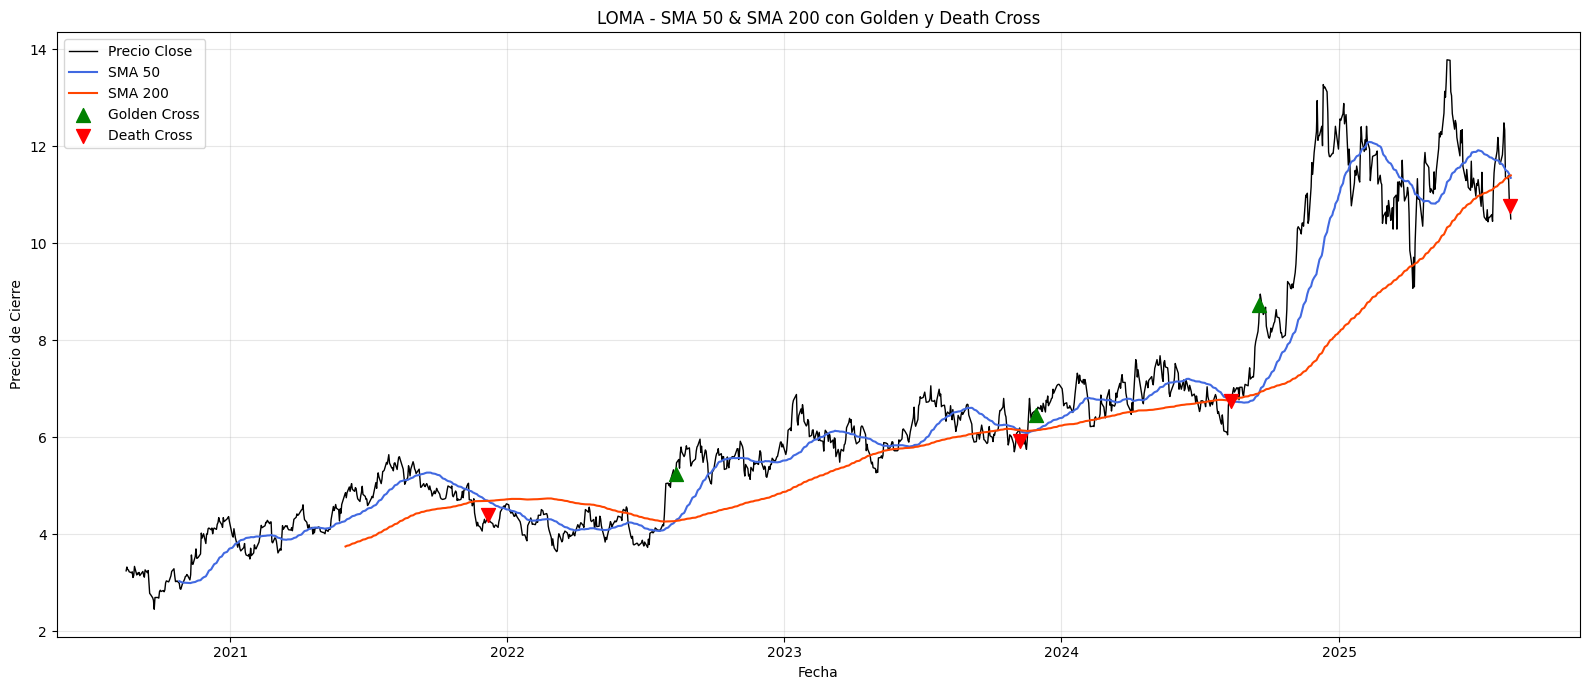

In [5]:
# 1. Calcular SMA 50 y SMA 200 sobre 'Close'
# Use calcular_medias_moviles from the technical_analysis module
sma_data = calcular_medias_moviles(loma_data['Close'], ventanas=[50, 200], tipo='SMA')
sma_50 = sma_data['SMA_50']
sma_200 = sma_data['SMA_200']


# 2. Detectar Golden Cross (SMA 50 cruza arriba de 200), Death Cross (SMA 50 cruza abajo de 200)
cruce_golden = (sma_50 > sma_200) & (sma_50.shift(1) <= sma_200.shift(1))
cruce_death = (sma_50 < sma_200) & (sma_50.shift(1) >= sma_200.shift(1))

# 3. Graficar precio, SMAs y marcar los cruces
import matplotlib.pyplot as plt

plt.figure(figsize=(16,7))
plt.plot(loma_data.index, loma_data['Close'], label='Precio Close', color='black', linewidth=1)
plt.plot(sma_50, label='SMA 50', color='royalblue', linewidth=1.5)
plt.plot(sma_200, label='SMA 200', color='orangered', linewidth=1.5)

# Marcar Golden Cross (flecha hacia arriba)
plt.scatter(loma_data.index[cruce_golden], loma_data['Close'][cruce_golden], marker='^', color='green', label='Golden Cross', s=100, zorder=5)
# Marcar Death Cross (flecha hacia abajo)
plt.scatter(loma_data.index[cruce_death], loma_data['Close'][cruce_death], marker='v', color='red', label='Death Cross', s=100, zorder=5)

plt.title("LOMA - SMA 50 & SMA 200 con Golden y Death Cross")
plt.ylabel("Precio de Cierre")
plt.xlabel("Fecha")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

###Backtesting estrategia de cruces SMA 50/200 vs Buy & Hold
inversión inicial $1000

🔄 Ejecutando backtesting...
   💰 Capital inicial: $1,000
   💳 Comisión: 0.100%
✅ Backtesting completado:
   📈 Retorno estrategia: 7.66% anual
   📊 Retorno buy & hold: 26.56% anual
   ⚡ Sharpe estrategia: 0.230
   📉 Drawdown máximo: -31.65%
   🎯 Win rate: 0.0%
   💰 Comisiones pagadas: $7


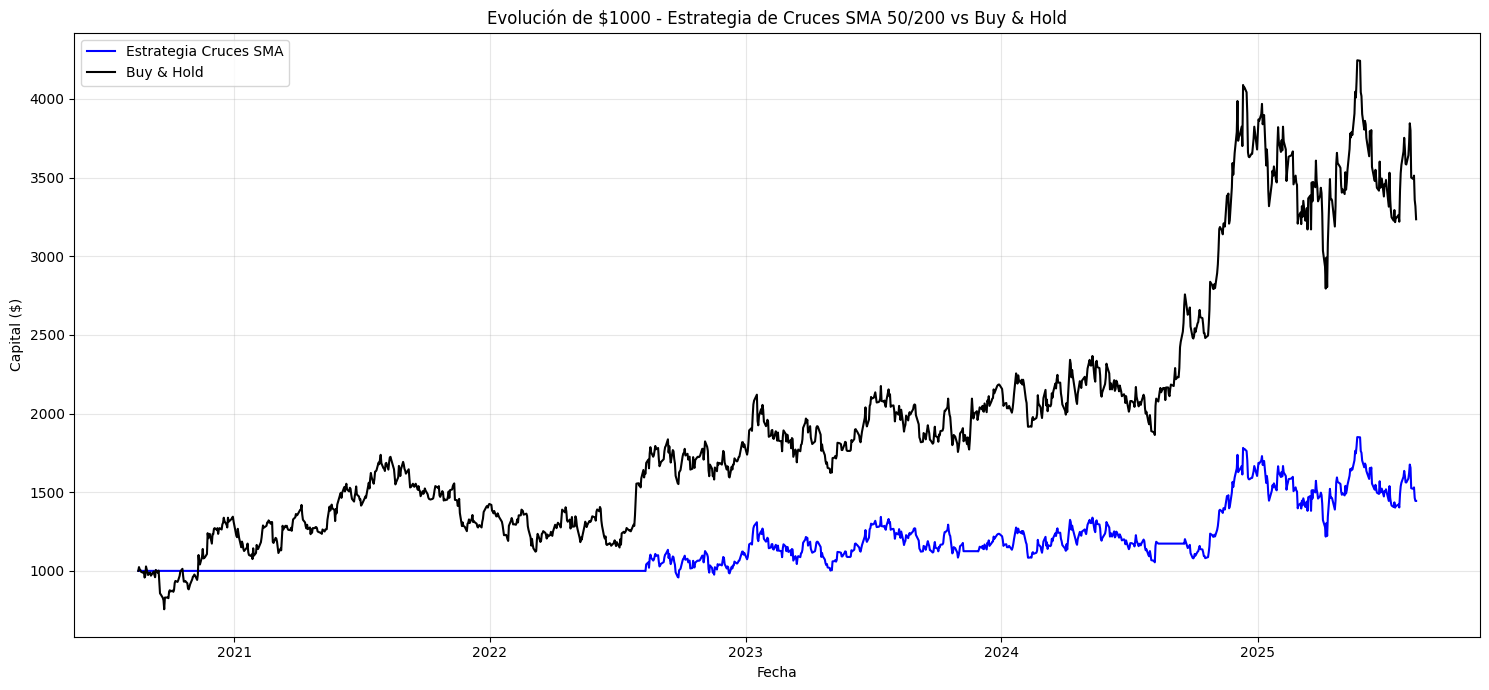


=== Métricas Backtest Estrategia Cruces SMA 50/200 vs Buy & Hold ===


,Cruces SMA 50/200,Buy & Hold
Metric,,
Capital Inicial,1000.000000,1000.000000
Capital Final,1444.773831,3234.935981
Retorno Total,0.444774,2.234936
Retorno Anualizado,0.076618,0.265604
Volatilidad Anualizada,0.333230,0.437470
Sharpe Ratio,0.229926,0.607137
Max Drawdown,-0.316503,-0.316503
Calmar Ratio,0.242077,NaN
Win Rate,0.000000,NaN


In [6]:
# 1. Crear señales de trading: 1=compra (Golden Cross), -1=venta (Death Cross), 0=mantener
# Empezamos "fuera", compramos sólo con Golden Cross, vendemos con Death Cross
señales = pd.Series(0, index=loma_data.index)
señales[cruce_golden] = 1
señales[cruce_death] = -1

# 2. Realizar Backtesting usando la función
resultados, metricas = backtest_estrategia(loma_data['Close'].squeeze(), señales, capital_inicial=1000, comision=0.001)

# 3. Graficar: Evolución capital estrategia y Buy & Hold en el mismo plot
capital_bnh = 1000 * (loma_data['Close'] / loma_data['Close'].iloc[0])

plt.figure(figsize=(15,7))
plt.plot(resultados.index, resultados['Capital'], label='Estrategia Cruces SMA', color='blue')
plt.plot(resultados.index, capital_bnh, label='Buy & Hold', color='black')
plt.title("Evolución de $1000 - Estrategia de Cruces SMA 50/200 vs Buy & Hold")
plt.ylabel("Capital ($)")
plt.xlabel("Fecha")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Mostrar métricas principales
print("\n=== Métricas Backtest Estrategia Cruces SMA 50/200 vs Buy & Hold ===")

# Preparar datos para la tabla comparativa
tabla_comparativa = {
    'Metric': [
        'Capital Inicial', 'Capital Final', 'Retorno Total',
        'Retorno Anualizado', 'Volatilidad Anualizada', 'Sharpe Ratio',
        'Max Drawdown', 'Calmar Ratio', 'Win Rate', 'Total Trades', 'Comisiones Totales'
    ],
    'Cruces SMA 50/200': [
        metricas['Capital_Inicial'], metricas['Capital_Final'], metricas['Retorno_Total'],
        metricas['Retorno_Anualizado_Estrategia'], metricas['Volatilidad_Estrategia'], metricas['Sharpe_Estrategia'],
        metricas['Max_Drawdown'], metricas['Calmar_Ratio'], metricas['Win_Rate'], metricas['Total_Trades'], metricas['Comisiones_Totales']
    ],
    'Buy & Hold': [
        metricas['Capital_Inicial'], capital_bnh.iloc[-1].iloc[0], (capital_bnh.iloc[-1].iloc[0] - metricas['Capital_Inicial']) / metricas['Capital_Inicial'],
        metricas['Retorno_Anualizado_BuyHold'], metricas['Volatilidad_BuyHold'], metricas['Sharpe_BuyHold'],
        metricas['Max_Drawdown'], None, None, None, None # Métricas no aplicables a Buy & Hold
    ]
}

# Convertir a DataFrame y mostrar
tabla_comparativa_df = pd.DataFrame(tabla_comparativa).set_index('Metric')
display(tabla_comparativa_df)

---
##2. Indicadores de Momentum

* MACD: Cálculo y análisis de divergencias.
* RSI: Identificar niveles de sobrecompra/sobreventa.
* ADX: Determinar fortaleza de tendencia.
* Optimización: Encontrar parámetros óptimos para tu activo específico.

---

###MACD

📊 Calculando MACD (12, 26, 9)
✅ MACD calculado con 50 señales de compra y 50 de venta


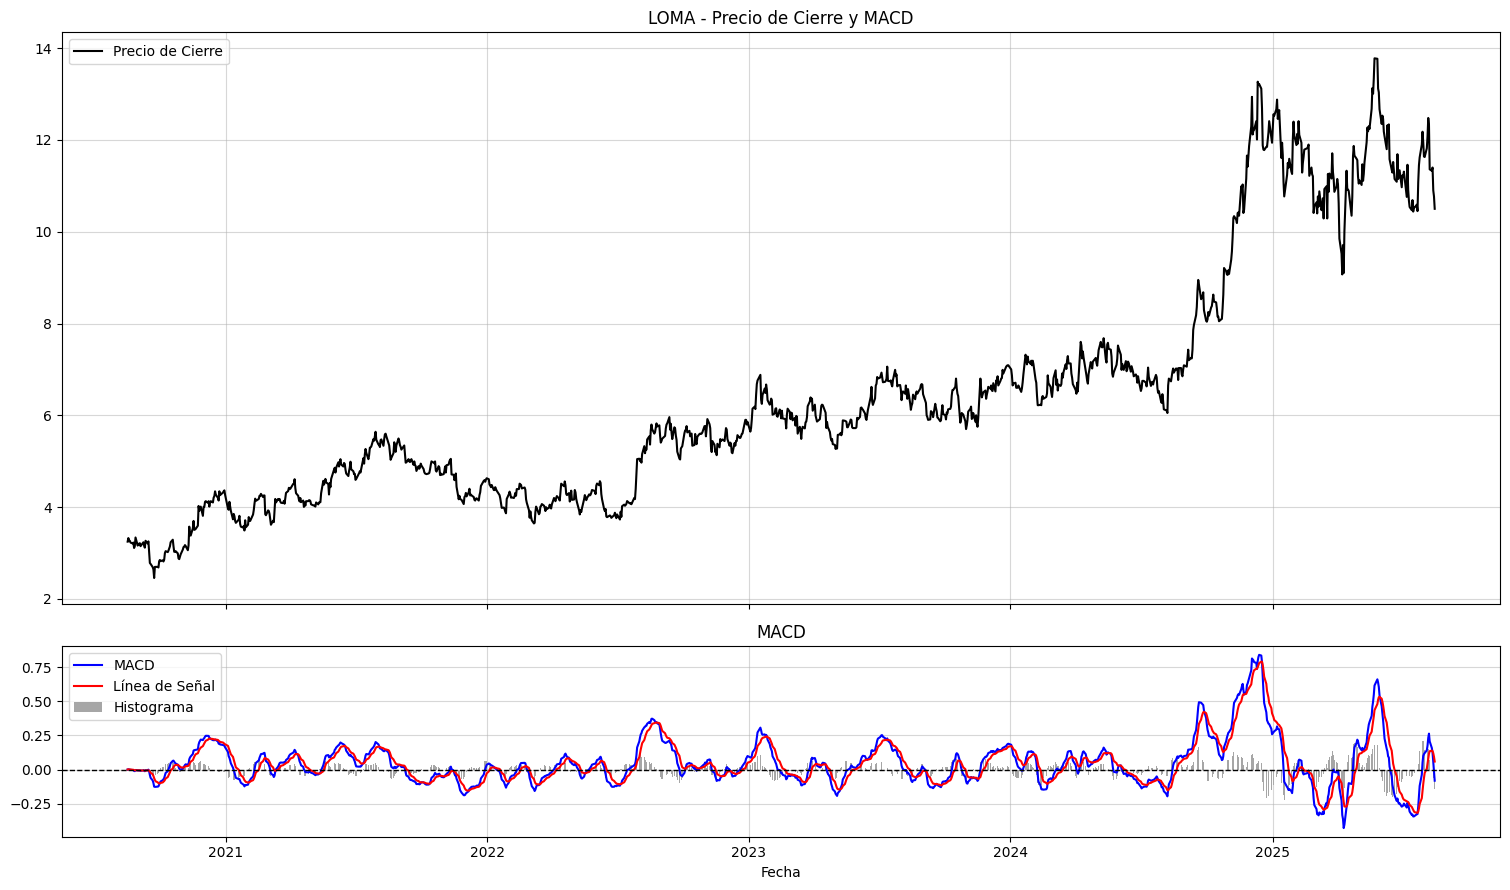

In [7]:
macd_data = calcular_macd(loma_data['Close'].squeeze())

# Estilo similar a Yahoo Finance: precio arriba, indicador abajo, ejes X compartidos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,9), sharex=True, gridspec_kw={'height_ratios': [3, 1]}) # Ajustar proporciones

# Gráfico de Precios
ax1.plot(loma_data.index, loma_data['Close'], label='Precio de Cierre', color='black', linewidth=1.5)
ax1.set_title('LOMA - Precio de Cierre y MACD')
ax1.grid(True, alpha=0.5)
ax1.legend()

# Gráfico de MACD
ax2.plot(macd_data.index, macd_data['MACD'], label='MACD', color='blue', linewidth=1.5)
ax2.plot(macd_data.index, macd_data['Señal'], label='Línea de Señal', color='red', linewidth=1.5)
ax2.bar(macd_data.index, macd_data['Histograma'], label='Histograma', color='gray', alpha=0.7)
ax2.axhline(0, color='black', linewidth=1, linestyle='--') # Línea cero
ax2.set_title('MACD')
ax2.grid(True, alpha=0.5)
ax2.legend()
ax2.set_xlabel("Fecha") # Añadir etiqueta al eje X en el subplot inferior

plt.tight_layout()
plt.show()



Las divergencias ocurren cuando el precio y el MACD se mueven en direcciones opuestas, lo que puede indicar un posible cambio en la tendencia.


*   Divergencias Alcistas: Buscamos momentos en que el precio hace mínimos más
bajos, pero el MACD hace mínimos más altos. Observando el gráfico, se pueden identificar algunos períodos (por ejemplo, a finales de 2020 y principios de 2021) donde el precio parecía hacer nuevos mínimos, pero el MACD mostraba una fortaleza relativa mayor, lo que coincidió con posteriores movimientos alcistas.
*   Divergencias Bajistas: Buscamos momentos en que el precio hace máximos más altos, pero el MACD hace máximos más bajos. Hacia finales de 2024 y principios de 2025, aunque el precio alcanzó nuevos máximos, el MACD mostró una ligera disminución en la fuerza, lo que podría interpretarse como una posible divergencia bajista, aunque la tendencia alcista se mantuvo fuerte.
Es importante recordar que las divergencias no siempre resultan en un cambio de tendencia y son más efectivas cuando se confirman con otras herramientas de análisis técnico.

###RSI

📊 Calculando RSI con período 14
📊 RSI calculado:
   Promedio: 52.5
   Señales sobrecompra (>70): 166
   Señales sobreventa (<30): 77


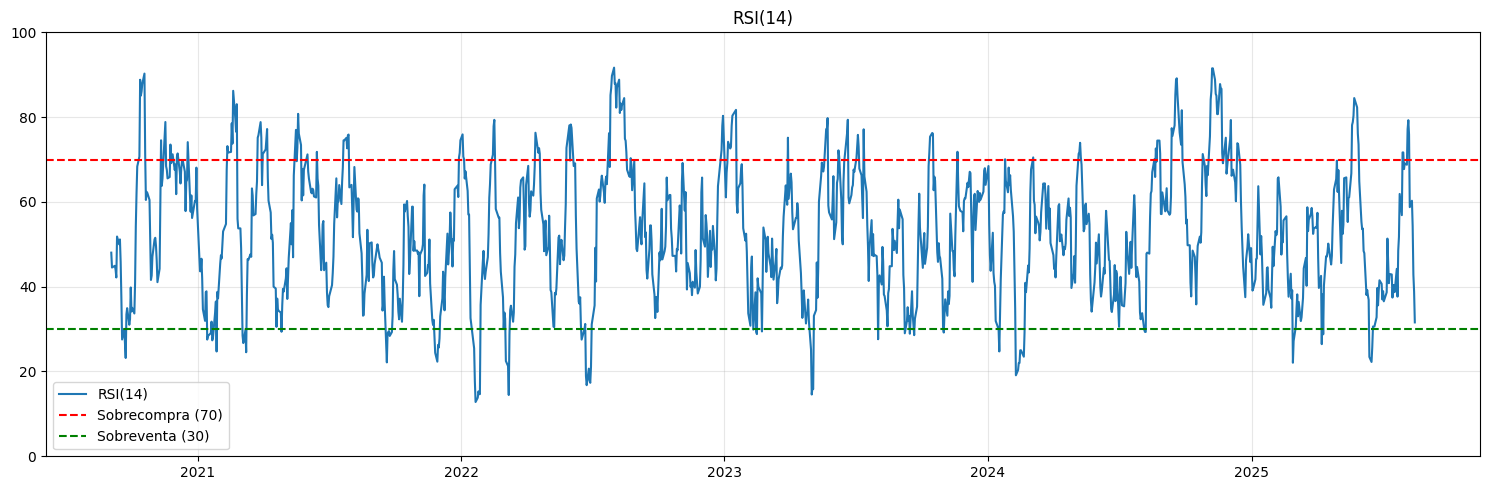

,Tipo de Señal,Cantidad
0,Sobrecompra (>70),166
1,Sobreventa (<30),77


In [8]:
rsi_14 = calcular_rsi(loma_data['Close'].squeeze(), periodo=14)

plt.figure(figsize=(15,5))
plt.plot(rsi_14.index, rsi_14, label='RSI(14)')
plt.axhline(70, color='red', linestyle='--', label='Sobrecompra (70)')
plt.axhline(30, color='green', linestyle='--', label='Sobreventa (30)')
plt.title('RSI(14)'); plt.ylim(0, 100); plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

rsi_sobrecompra = (rsi_14 > 70)
rsi_sobreventa  = (rsi_14 < 30)

# Crear una tabla con las fechas y el tipo de señal (originalmente)
# señales_rsi_tabla = pd.DataFrame(index=rsi_14.index)
# señales_rsi_tabla['RSI'] = rsi_14
# señales_rsi_tabla['Señal'] = 'Ninguna'
# señales_rsi_tabla.loc[rsi_sobrecompra, 'Señal'] = 'Sobrecompra (>70)'
# señales_rsi_tabla.loc[rsi_sobreventa, 'Señal'] = 'Sobreventa (<30)'

# Filtrar solo las filas con señales (originalmente)
# señales_rsi_tabla = señales_rsi_tabla[señales_rsi_tabla['Señal'] != 'Ninguna']

# Crear la tabla resumen con los conteos
resumen_señales_rsi = pd.DataFrame({
    'Tipo de Señal': ['Sobrecompra (>70)', 'Sobreventa (<30)'],
    'Cantidad': [rsi_sobrecompra.sum(), rsi_sobreventa.sum()]
})

display(resumen_señales_rsi)

# print(f"Señales de sobrecompra (>70): {rsi_sobrecompra.sum()}") # Comentado a pedido del usuario
# print(f"Señales de sobreventa (<30): {rsi_sobreventa.sum()}") # Comentado a pedido del usuario

# print("\nTabla de Señales RSI:") # Comentado a pedido del usuario
# display(señales_rsi_tabla) # Comentado a pedido del usuario

###ADX

📊 Calculando ADX con período 14
✅ ADX calculado:
   ADX promedio: 32.1
   Tendencias fuertes (ADX>25): 834 días


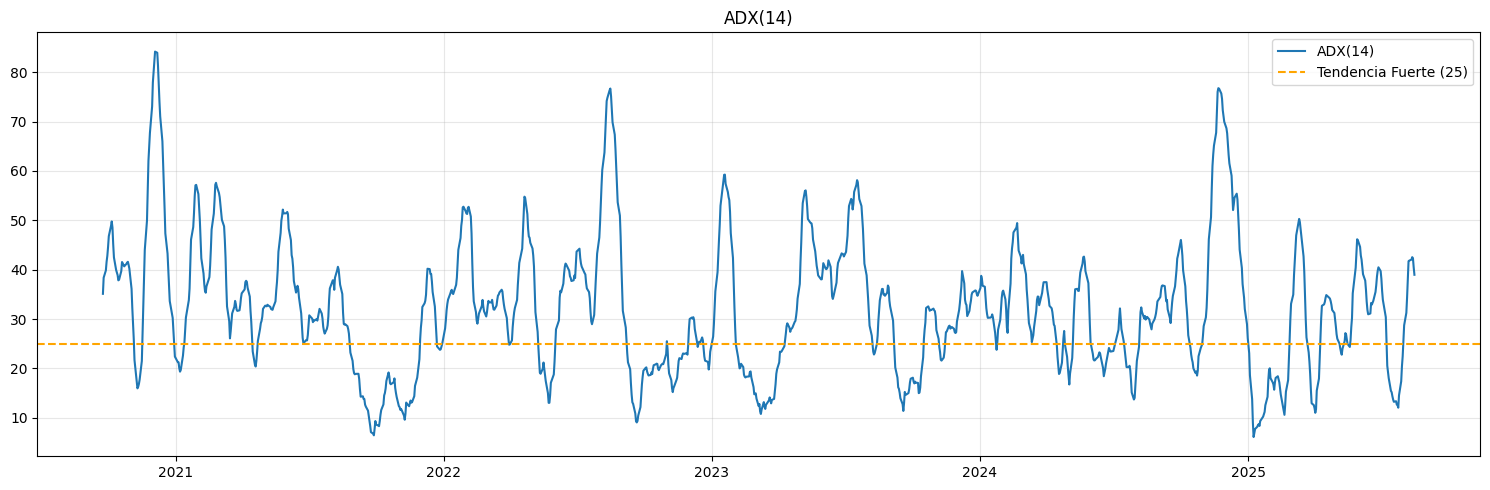

ADX promedio: 32.13


In [9]:
adx_14 = calcular_adx(loma_data['High'].squeeze(), loma_data['Low'].squeeze(), loma_data['Close'].squeeze(), periodo=14)

plt.figure(figsize=(15,5))
plt.plot(adx_14.index, adx_14['ADX'], label='ADX(14)')
plt.axhline(25, color='orange', linestyle='--', label='Tendencia Fuerte (25)')
plt.title('ADX(14)'); plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

print(f"ADX promedio: {adx_14['ADX'].mean():.2f}")

###Optimizacion de parametros

Optimizacion de MACD

In [10]:
# Optimización de MACD (búsqueda de hiperparámetros por Sharpe)

import itertools
import pandas as pd
import numpy as np
import contextlib, os

# --- Configuración de la grilla de búsqueda ---
rango_rapido = range(10, 21)
rango_lento  = range(30, 41)
rango_senal  = [5, 7, 9]

capital_inicial = 1000
comision = 0.001  # 0.1%

resultados_opt = []

precios = loma_data['Close'].squeeze()

for pr, pl, ps in itertools.product(rango_rapido, rango_lento, rango_senal):
    if pl <= pr:   # MACD clásico: lento > rápido
        continue

    # Silenciar prints de las funciones durante el loop
    with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
        macd_df = calcular_macd(precios, periodo_rapido=pr, periodo_lento=pl, periodo_señal=ps)
        # Señales por cruce MACD vs Señal (1=Buy, -1=Sell, 0=Hold)
        senales_macd = macd_df['Cruce_MACD'].reindex(precios.index).fillna(0)

        _, metr = backtest_estrategia(
            precios, senales_macd,
            capital_inicial=capital_inicial,
            comision=comision
        )

    metr['MACD_Fast'] = pr
    metr['MACD_Slow'] = pl
    metr['MACD_Signal'] = ps
    resultados_opt.append(metr)

# Tabla de resultados
res_macd = pd.DataFrame(resultados_opt)

print("\n=== Resultados Optimización MACD por Sharpe Ratio ===")
tabla_ordenada = (
    res_macd
    .sort_values('Sharpe_Estrategia', ascending=False)
    .reset_index(drop=True)
)
display(
    tabla_ordenada[
        ['MACD_Fast','MACD_Slow','MACD_Signal',
         'Sharpe_Estrategia','Retorno_Anualizado_Estrategia',
         'Volatilidad_Estrategia','Max_Drawdown','Win_Rate','Total_Trades']
    ].head(20).T
)

# Mejor combinación
idx_best = res_macd['Sharpe_Estrategia'].idxmax()
mejor = res_macd.loc[idx_best]

print(f"\nMejor MACD -> Fast: {int(mejor['MACD_Fast'])} | Slow: {int(mejor['MACD_Slow'])} | Signal: {int(mejor['MACD_Signal'])}")
print(f"Sharpe: {mejor['Sharpe_Estrategia']:.3f} | Ret Anual: {mejor['Retorno_Anualizado_Estrategia']:.2%} | "
      f"Vol: {mejor['Volatilidad_Estrategia']:.2%} | MDD: {mejor['Max_Drawdown']:.2%} | WinRate: {mejor['Win_Rate']:.1%}")


=== Resultados Optimización MACD por Sharpe Ratio ===


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
MACD_Fast,12.000000,12.000000,12.000000,13.000000,17.000000,13.000000,18.000000,12.000000,13.000000,13.000000,11.000000,11.000000,18.000000,14.000000,13.000000,11.000000,13.000000,11.000000,13.000000,17.000000
MACD_Slow,38.000000,39.000000,37.000000,39.000000,33.000000,34.000000,31.000000,36.000000,33.000000,40.000000,39.000000,40.000000,30.000000,35.000000,31.000000,33.000000,30.000000,32.000000,36.000000,32.000000
MACD_Signal,7.000000,7.000000,7.000000,5.000000,5.000000,7.000000,5.000000,7.000000,7.000000,5.000000,7.000000,7.000000,5.000000,5.000000,9.000000,9.000000,9.000000,7.000000,5.000000,5.000000
Sharpe_Estrategia,0.468202,0.463035,0.450466,0.447037,0.430711,0.426550,0.413599,0.410591,0.408831,0.403094,0.396463,0.396463,0.389313,0.385321,0.385177,0.383171,0.382422,0.382413,0.381121,0.380492
Retorno_Anualizado_Estrategia,0.143133,0.141538,0.137944,0.133797,0.130742,0.130531,0.125359,0.125406,0.125451,0.120922,0.121203,0.121203,0.117490,0.115554,0.117746,0.117661,0.116906,0.114384,0.113929,0.114764
Volatilidad_Estrategia,0.305707,0.305674,0.306226,0.299298,0.303550,0.306016,0.303092,0.305429,0.306853,0.299986,0.305711,0.305711,0.301787,0.299890,0.305693,0.307072,0.305700,0.299111,0.298930,0.301620
Max_Drawdown,-0.453081,-0.453263,-0.453081,-0.453754,-0.462096,-0.453081,-0.455913,-0.448077,-0.448077,-0.453754,-0.440342,-0.440342,-0.446701,-0.458166,-0.393794,-0.434164,-0.393794,-0.465906,-0.463002,-0.446701
Win_Rate,0.034884,0.034884,0.023256,0.088235,0.063830,0.034884,0.063830,0.033333,0.034091,0.068627,0.063830,0.063830,0.062500,0.078431,0.025000,0.035714,0.025000,0.064815,0.063636,0.071429
Total_Trades,86.000000,86.000000,86.000000,102.000000,94.000000,86.000000,94.000000,90.000000,88.000000,102.000000,94.000000,94.000000,96.000000,102.000000,80.000000,84.000000,80.000000,108.000000,110.000000,98.000000



Mejor MACD -> Fast: 12 | Slow: 38 | Signal: 7
Sharpe: 0.468 | Ret Anual: 14.31% | Vol: 30.57% | MDD: -45.31% | WinRate: 3.5%


Optimizacion de RSI

In [11]:
# Optimización simple de RSI (búsqueda de ventana con mejor Sharpe)

# Usa backtest_estrategia con regla RSI: comprar cuando cruza desde <30 hacia arriba, vender cuando cruza >70 hacia abajo.

import contextlib
import os

resultados_optimizacion = []

for ventana in range(10, 21):
    # Suppress all output from the functions within the loop
    with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
        rsi_tmp = calcular_rsi(loma_data['Close'].squeeze(), periodo=ventana)
        # Señales RSI básicas (1=Buy al salir de sobreventa, -1=Sell al salir de sobrecompra)
        señales_rsi = pd.Series(0, index=loma_data.index)
        señales_rsi[(rsi_tmp.shift(1) < 30) & (rsi_tmp >= 30)] = 1
        señales_rsi[(rsi_tmp.shift(1) > 70) & (rsi_tmp <= 70)] = -1

        _, metr = backtest_estrategia(loma_data['Close'].squeeze(), señales_rsi, capital_inicial=1000, comision=0.001)

    # Almacenar resultados
    metr['Ventana_RSI'] = ventana
    resultados_optimizacion.append(metr)


# Convertir resultados a DataFrame para mostrar en tabla
resultados_df = pd.DataFrame(resultados_optimizacion)

# Mostrar tabla de resultados
print("\n=== Resultados Optimización RSI por Sharpe Ratio ===")
display(resultados_df.set_index('Ventana_RSI').sort_values('Sharpe_Estrategia', ascending=False).T)

# Encontrar y mostrar la mejor ventana
mejor_resultado = resultados_df.loc[resultados_df['Sharpe_Estrategia'].idxmax()]
print(f"\nMejor ventana RSI: {int(mejor_resultado['Ventana_RSI'])} con Sharpe {mejor_resultado['Sharpe_Estrategia']:.3f}")


=== Resultados Optimización RSI por Sharpe Ratio ===


Ventana_RSI,15,17,16,13,14,19,11,18,12,10,20
Capital_Inicial,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
Capital_Final,3664.151704,3010.797761,2411.983913,2535.679106,2342.525334,2506.753789,2293.956709,2011.938163,1923.792412,2109.190866,1685.925525
Retorno_Total,2.664152,2.010798,1.411984,1.535679,1.342525,1.506754,1.293957,1.011938,0.923792,1.109191,0.685926
Retorno_Anualizado_Estrategia,0.297639,0.247502,0.193214,0.205248,0.186239,0.202476,0.181263,0.150579,0.140283,0.161528,0.110484
Retorno_Anualizado_BuyHold,0.265604,0.265604,0.265604,0.265604,0.265604,0.265604,0.265604,0.265604,0.265604,0.265604,0.265604
Volatilidad_Estrategia,0.275545,0.254050,0.235211,0.289635,0.264587,0.299160,0.274799,0.237832,0.261767,0.302053,0.243171
Volatilidad_BuyHold,0.437470,0.437470,0.437470,0.437470,0.437470,0.437470,0.437470,0.437470,0.437470,0.437470,0.437470
Sharpe_Estrategia,1.080183,0.974225,0.821449,0.708642,0.703888,0.676817,0.659622,0.633130,0.535907,0.534766,0.454345
Sharpe_BuyHold,0.607137,0.607137,0.607137,0.607137,0.607137,0.607137,0.607137,0.607137,0.607137,0.607137,0.607137
Max_Drawdown,-0.260101,-0.225448,-0.225448,-0.247589,-0.225448,-0.234890,-0.225448,-0.234890,-0.247589,-0.276715,-0.278846



Mejor ventana RSI: 15 con Sharpe 1.080


Optimizacion de ADX

In [12]:
# Optimización de ADX (periodo + umbral de tendencia) por Sharpe

import pandas as pd
import numpy as np
import contextlib, os
import itertools

# === Configuración ===
periodos_adx   = range(10, 31)          # 10..30
umbrales_adx   = [20, 25, 30]           # filtros de fuerza de tendencia
capital_inicial = 1000
comision        = 0.001                 # 0.1%

precios_close = loma_data['Close'].squeeze()
precios_high  = loma_data['High'].squeeze()
precios_low   = loma_data['Low'].squeeze()

resultados_opt = []

for p, thr in itertools.product(periodos_adx, umbrales_adx):

    # Silencia prints dentro del loop
    with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
        adx_df = calcular_adx(precios_high, precios_low, precios_close, periodo=p)

    # Validación mínima
    if adx_df is None or adx_df.empty or not all(c in adx_df.columns for c in ['ADX', '+DI', '-DI']):
        continue

    # Señales por cruces de +DI/-DI con filtro ADX >= umbral
    datos = adx_df.copy()
    datos = datos.reindex(precios_close.index).dropna()

    senales = pd.Series(0, index=datos.index)

    # Compra: +DI cruza por encima de -DI y ADX >= thr
    compra = (datos['+DI'] > datos['-DI']) & (datos['+DI'].shift(1) <= datos['-DI'].shift(1)) & (datos['ADX'] >= thr)
    # Venta: -DI cruza por encima de +DI y ADX >= thr
    venta  = (datos['-DI'] > datos['+DI']) & (datos['-DI'].shift(1) <= datos['+DI'].shift(1)) & (datos['ADX'] >= thr)

    senales.loc[compra] = 1
    senales.loc[venta]  = -1

    # Backtest con tus utilidades
    with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
        _, metr = backtest_estrategia(precios_close.reindex(senales.index), senales,
                                      capital_inicial=capital_inicial, comision=comision)

    # Guardar métricas + hiperparámetros
    metr['ADX_Periodo']  = p
    metr['ADX_Umbral']   = thr
    resultados_opt.append(metr)

# Resultados en tabla
res_adx = pd.DataFrame(resultados_opt)

print("\n=== Resultados Optimización ADX por Sharpe Ratio ===")
if not res_adx.empty:
    tabla_ordenada = (
        res_adx.sort_values('Sharpe_Estrategia', ascending=False)
               .reset_index(drop=True)
    )
    display(
        tabla_ordenada[
            ['ADX_Periodo','ADX_Umbral',
             'Sharpe_Estrategia','Retorno_Anualizado_Estrategia',
             'Volatilidad_Estrategia','Max_Drawdown','Win_Rate','Total_Trades']
        ].head(20).T
    )

    # Mejor combinación
    best_idx = res_adx['Sharpe_Estrategia'].idxmax()
    best = res_adx.loc[best_idx]
    print(f"\nMejor ADX -> Periodo: {int(best['ADX_Periodo'])} | Umbral: {int(best['ADX_Umbral'])}")
    print(f"Sharpe: {best['Sharpe_Estrategia']:.3f} | Ret Anual: {best['Retorno_Anualizado_Estrategia']:.2%} | "
          f"Vol: {best['Volatilidad_Estrategia']:.2%} | MDD: {best['Max_Drawdown']:.2%} | WinRate: {best['Win_Rate']:.1%}")
else:
    print("No se pudieron calcular resultados (revisá que loma_data tenga columnas High/Low/Close y que calcular_adx esté disponible).")



=== Resultados Optimización ADX por Sharpe Ratio ===


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ADX_Periodo,16.000000,18.000000,17.000000,16.000000,21.000000,15.000000,27.000000,15.000000,14.000000,19.000000,18.000000,19.000000,27.000000,25.000000,22.000000,17.000000,16.000000,24.000000,18.000000,13.000000
ADX_Umbral,20.000000,25.000000,20.000000,25.000000,30.000000,25.000000,20.000000,30.000000,30.000000,20.000000,20.000000,25.000000,25.000000,20.000000,30.000000,25.000000,30.000000,25.000000,30.000000,20.000000
Sharpe_Estrategia,0.879263,0.708994,0.697196,0.651195,0.646045,0.639474,0.624310,0.593903,0.576775,0.575915,0.574036,0.560036,0.549697,0.527277,0.489969,0.483625,0.483073,0.479025,0.455623,0.446169
Retorno_Anualizado_Estrategia,0.302705,0.202450,0.217921,0.209202,0.156000,0.201302,0.176986,0.191552,0.173226,0.170849,0.185927,0.151304,0.124581,0.165957,0.135205,0.133905,0.151500,0.121310,0.132731,0.143186
Volatilidad_Estrategia,0.344271,0.285546,0.312568,0.321259,0.241469,0.314793,0.283490,0.322530,0.300335,0.296656,0.323895,0.270168,0.226636,0.314743,0.275947,0.276877,0.313617,0.253243,0.291318,0.320924
Max_Drawdown,-0.348651,-0.311014,-0.310660,-0.361987,-0.273347,-0.266043,-0.284655,-0.337021,-0.342734,-0.345635,-0.339958,-0.292754,-0.259048,-0.281867,-0.354244,-0.347333,-0.355142,-0.246134,-0.320275,-0.471502
Win_Rate,0.101695,0.156250,0.062500,0.088889,0.058824,0.129630,0.190476,0.135135,0.159091,0.072727,0.142857,0.055556,0.142857,0.205882,0.250000,0.096774,0.111111,0.000000,0.142857,0.188235
Total_Trades,59.000000,32.000000,48.000000,45.000000,17.000000,54.000000,21.000000,37.000000,44.000000,55.000000,49.000000,36.000000,14.000000,34.000000,12.000000,31.000000,27.000000,20.000000,21.000000,85.000000



Mejor ADX -> Periodo: 16 | Umbral: 20
Sharpe: 0.879 | Ret Anual: 30.27% | Vol: 34.43% | MDD: -34.87% | WinRate: 10.2%


---
##3. Análisis de Volatilidad

* Bandas de Bollinger: Análisis de compresión/expansión.
* Calcular % de tiempo fuera de bandas.
* Identificar señales de compra/venta.

---

📊 Calculando Bandas de Bollinger (20 períodos, 2 std)
📊 Estadísticas Bollinger:
   Ancho promedio bandas: 17.51%
   Tiempo fuera de bandas: 10.3%
   Señales generadas: 68


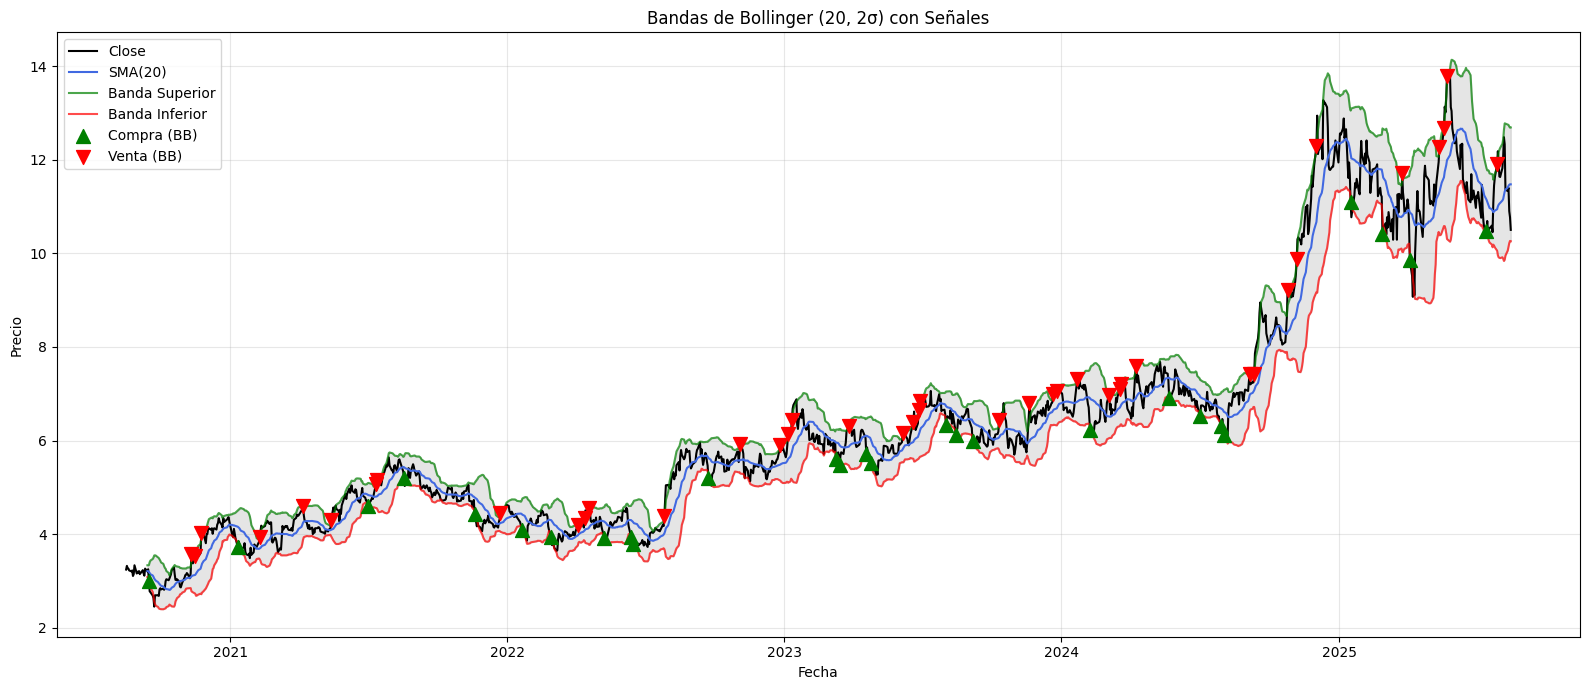

,Métrica,Valor
0,% Tiempo fuera de bandas,10.27%
1,Ancho promedio de banda,17.51%


In [13]:
bollinger_data_plot = calcular_bollinger_bands(loma_data['Close'].squeeze(), periodo=20, std_dev=2)

plt.figure(figsize=(16,7))
plt.plot(bollinger_data_plot.index, bollinger_data_plot['Precio'], label='Close', color='black')
plt.plot(bollinger_data_plot.index, bollinger_data_plot['SMA'], label='SMA(20)', color='royalblue')
plt.plot(bollinger_data_plot.index, bollinger_data_plot['Banda_Superior'], label='Banda Superior', color='green', alpha=0.7)
plt.plot(bollinger_data_plot.index, bollinger_data_plot['Banda_Inferior'], label='Banda Inferior', color='red', alpha=0.7)
plt.fill_between(bollinger_data_plot.index, bollinger_data_plot['Banda_Inferior'], bollinger_data_plot['Banda_Superior'], color='black', alpha=0.1)

# Añadir señales de compra/venta al gráfico
buy_signals = bollinger_data_plot[bollinger_data_plot['Señal'] == 'Buy']
sell_signals = bollinger_data_plot[bollinger_data_plot['Señal'] == 'Sell']

plt.scatter(buy_signals.index, buy_signals['Precio'], marker='^', color='green', label='Compra (BB)', s=100, zorder=5)
plt.scatter(sell_signals.index, sell_signals['Precio'], marker='v', color='red', label='Venta (BB)', s=100, zorder=5)

plt.title('Bandas de Bollinger (20, 2σ) con Señales')
plt.xlabel('Fecha'); plt.ylabel('Precio'); plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

fuera_bandas = ((bollinger_data_plot['Precio'] > bollinger_data_plot['Banda_Superior']) | (bollinger_data_plot['Precio'] < bollinger_data_plot['Banda_Inferior']))
pct_fuera = 100 * fuera_bandas.sum() / fuera_bandas.count()
ancho_banda = (bollinger_data_plot['Banda_Superior'] - bollinger_data_plot['Banda_Inferior']) / bollinger_data_plot['SMA']

# Crear tabla con las métricas
metricas_bb = pd.DataFrame({
    'Métrica': ['% Tiempo fuera de bandas', 'Ancho promedio de banda'],
    'Valor': [f"{pct_fuera:.2f}%", f"{ancho_banda.mean():.2%}"]
})

display(metricas_bb)

# print(f"% de tiempo fuera de bandas: {pct_fuera:.2f}%") # Comentado a pedido del usuario
# print(f"Ancho promedio de banda: {ancho_banda.mean():.2%}") # Comentado a pedido del usuario

Análisis de Volatilidad – Bandas de Bollinger

*   Cuando las bandas se estrechan (compresión), la volatilidad es baja y suele anticipar un movimiento fuerte en el precio.
*   Cuando las bandas se ensanchan (expansión), hay alta volatilidad y generalmente acompañan movimientos de precios intensos.
*   Si el precio toca o supera la banda superior, puede indicar sobrecompra o una tendencia alcista fuerte; si toca o baja la banda inferior, puede señalar sobreventa o tendencia bajista fuerte.
*   **El precio de LOMA estuvo fuera de las bandas el 10,3%** del tiempo analizado; esto puede señalar tendencias muy fuertes o, si vuelve rápidamente dentro de las bandas, posible agotamiento del movimiento.
*   Una estrategia común es operar rebotes: comprar cuando el precio toca la banda inferior y sube, o vender al tocar la superior y bajar, especialmente en mercados laterales.

---
##4. Estrategia Integral y Backtesting
* Combinar todos los indicadores en una estrategia coherente.
* Backtesting con métricas:.
  * Sharpe Ratio.
  * Calmar Ratio.
  * Win Rate.
  * Drawdown máximo.

---

###Estrategia Integral

In [14]:
# ============================================================
# Estrategia Integral Combinada (Generación de Señales)
# ============================================================

import pandas as pd
import numpy as np

# Asegurarse de que los indicadores y sus parámetros óptimos estén disponibles
# SMA 50/200 (asumimos calculados previamente en loma_data)
# MACD (con parámetros óptimos)
# RSI (con parámetro óptimo)
# ADX (con parámetros óptimos)
# Bandas de Bollinger (con parámetros por defecto, si no se optimizaron)

try:
    # Obtener parámetros óptimos
    rsi_win_opt = int(mejor_resultado['Ventana_RSI'])
    macd_fast_opt = int(mejor['MACD_Fast'])
    macd_slow_opt = int(mejor['MACD_Slow'])
    macd_signal_opt = int(mejor['MACD_Signal'])
    adx_period_opt = int(best['ADX_Periodo'])
    adx_umbral_opt = int(best['ADX_Umbral'])
except (NameError, KeyError) as e:
    print(f"Error al obtener parámetros óptimos: {e}. Asegúrate de ejecutar las celdas de optimización.")
    # Usar valores por defecto si no se encuentran los óptimos
    rsi_win_opt = 14
    macd_fast_opt, macd_slow_opt, macd_signal_opt = 12, 26, 9
    adx_period_opt, adx_umbral_opt = 14, 25
    print("Usando parámetros por defecto.")


# Recalcular indicadores con parámetros óptimos en el mismo índice de loma_data
precios_cierre_squeeze = loma_data['Close'].squeeze()
precios_high_squeeze = loma_data['High'].squeeze()
precios_low_squeeze = loma_data['Low'].squeeze()

# Asegurarse de tener SMA_50 y SMA_200 (calculados en celdas anteriores)
try:
    _ = sma_50
    _ = sma_200
except NameError:
    print("SMA_50 y SMA_200 no encontrados. Calculando...")
    mm_data = calcular_medias_moviles(precios_cierre_squeeze, ventanas=[50, 200], tipo='SMA')
    sma_50 = mm_data['SMA_50']
    sma_200 = mm_data['SMA_200']


macd_opt = calcular_macd(precios_cierre_squeeze, periodo_rapido=macd_fast_opt, periodo_lento=macd_slow_opt, periodo_señal=macd_signal_opt)
rsi_opt = calcular_rsi(precios_cierre_squeeze, periodo=rsi_win_opt)
adx_opt = calcular_adx(precios_high_squeeze, precios_low_squeeze, precios_cierre_squeeze, periodo=adx_period_opt)
bollinger_opt = calcular_bollinger_bands(precios_cierre_squeeze, periodo=20, std_dev=2) # Usar params por defecto para BB


# Combinar todos los datos de indicadores en un solo DataFrame, reindexando y eliminando NaNs
# Usar el índice de loma_data como base
combined_data = pd.DataFrame({
    'Close': precios_cierre_squeeze,
    'SMA_50': sma_50,
    'SMA_200': sma_200,
    'RSI': rsi_opt,
    'MACD_Line': macd_opt['MACD'],
    'MACD_Signal': macd_opt['Señal'],
    'ADX': adx_opt['ADX'],
    '+DI': adx_opt['+DI'],
    '-DI': adx_opt['-DI'],
    'BB_Lower': bollinger_opt['Banda_Inferior'],
    'BB_Upper': bollinger_opt['Banda_Superior'],
    'BB_SMA_20': bollinger_opt['SMA'] # Media móvil de BB
}).dropna() # Eliminar filas con NaNs resultantes de los períodos iniciales de los indicadores


# --- Definir la lógica de la Estrategia Integral Combinada ---
# Esta es una propuesta de lógica. Puedes ajustarla según tus criterios.
# Buscamos señales que se confirmen entre sí:
# Entrar Largo (señal = 1):
# 1. Tendencia alcista confirmada: SMA50 > SMA200 Y ADX > umbral_ADX óptimo Y +DI > -DI
# 2. Momentum alcista: MACD_Line > MACD_Signal O RSI saliendo de sobreventa (RSI.shift(1) < 30 & RSI >= 30)
# 3. Precio por encima de la media de Bollinger o saliendo de banda inferior: Close > BB_SMA_20 O (Close.shift(1) < BB_Lower.shift(1) & Close >= BB_Lower)

# Salir de Largo (señal = -1):
# 1. Pérdida de tendencia alcista o inicio de bajista: SMA50 < SMA200 O ADX < umbral_ADX óptimo O +DI < -DI
# 2. Momentum bajista: MACD_Line < MACD_Signal O RSI entrando en sobrecompra (RSI.shift(1) > 70 & RSI <= 70)
# 3. Precio por debajo de la media de Bollinger o saliendo de banda superior: Close < BB_SMA_20 O (Close.shift(1) > BB_Upper.shift(1) & Close <= BB_Upper)


senales_integral_combinada = pd.Series(0, index=combined_data.index, dtype=int)
posicion = 0 # 0 = fuera, 1 = largo

for i in range(len(combined_data)):
    fecha = combined_data.index[i]

    # Condiciones en la fecha actual
    sma_alcista_cond = (combined_data['SMA_50'].loc[fecha] > combined_data['SMA_200'].loc[fecha])
    adx_tendencia_fuerte_cond = (combined_data['ADX'].loc[fecha] > adx_umbral_opt)
    adx_dir_alcista_cond = (combined_data['+DI'].loc[fecha] > combined_data['-DI'].loc[fecha])
    momentum_macd_alcista_cond = (combined_data['MACD_Line'].loc[fecha] > combined_data['MACD_Signal'].loc[fecha])
    momentum_rsi_sobreventa_salida_cond = False # Calcular con valores de un día antes
    if i > 0:
         momentum_rsi_sobreventa_salida_cond = (combined_data['RSI'].iloc[i-1] < 30) and (combined_data['RSI'].iloc[i] >= 30)

    bb_encima_media_cond = (combined_data['Close'].loc[fecha] > combined_data['BB_SMA_20'].loc[fecha])
    bb_salida_inferior_cond = False # Calcular con valores de un día antes
    if i > 0:
        bb_salida_inferior_cond = (combined_data['Close'].iloc[i-1] < combined_data['BB_Lower'].iloc[i-1]) and (combined_data['Close'].iloc[i] >= combined_data['BB_Lower'].iloc[i])


    sma_bajista_cond = (combined_data['SMA_50'].loc[fecha] < combined_data['SMA_200'].loc[fecha])
    adx_dir_bajista_cond = (combined_data['+DI'].loc[fecha] < combined_data['-DI'].loc[fecha]) # Ojo, ADX bajo no implica bajista, solo debil
    momentum_macd_bajista_cond = (combined_data['MACD_Line'].loc[fecha] < combined_data['MACD_Signal'].loc[fecha])
    momentum_rsi_sobrecompra_salida_cond = False # Calcular con valores de un día antes
    if i > 0:
        momentum_rsi_sobrecompra_salida_cond = (combined_data['RSI'].iloc[i-1] > 70) and (combined_data['RSI'].iloc[i] <= 70)

    bb_debajo_media_cond = (combined_data['Close'].loc[fecha] < combined_data['BB_SMA_20'].loc[fecha])
    bb_salida_superior_cond = False # Calcular con valores de un día antes
    if i > 0:
        bb_salida_superior_cond = (combined_data['Close'].iloc[i-1] > combined_data['BB_Upper'].iloc[i-1]) and (combined_data['Close'].iloc[i] <= combined_data['BB_Upper'].iloc[i])


    # --- Lógica de Entrada (si estoy fuera y decido comprar) ---
    if posicion == 0:
        condicion_entrada = sma_alcista_cond and adx_tendencia_fuerte_cond and adx_dir_alcista_cond and \
                            (momentum_macd_alcista_cond or momentum_rsi_sobreventa_salida_cond) and \
                            (bb_encima_media_cond or bb_salida_inferior_cond)

        if condicion_entrada:
            senales_integral_combinada.loc[fecha] = 1 # Señal de compra
            posicion = 1

    # --- Lógica de Salida (si estoy dentro y decido vender) ---
    elif posicion == 1:
        condicion_salida = sma_bajista_cond or not adx_tendencia_fuerte_cond or adx_dir_bajista_cond or \
                           momentum_macd_bajista_cond or momentum_rsi_sobrecompra_salida_cond or \
                           bb_debajo_media_cond or bb_salida_superior_cond

        if condicion_salida:
            senales_integral_combinada.loc[fecha] = -1 # Señal de venta
            posicion = 0

    # Si no hay señal de cambio, la señal es 0 (mantener)


print("Señales de estrategia integral combinada generadas.")
# La backtesting y visualización se hará en la próxima celda.

📊 Calculando MACD (12, 38, 7)
✅ MACD calculado con 43 señales de compra y 43 de venta
📊 Calculando RSI con período 15
📊 RSI calculado:
   Promedio: 52.5
   Señales sobrecompra (>70): 149
   Señales sobreventa (<30): 69
📊 Calculando ADX con período 16
✅ ADX calculado:
   ADX promedio: 29.4
   Tendencias fuertes (ADX>25): 748 días
📊 Calculando Bandas de Bollinger (20 períodos, 2 std)
📊 Estadísticas Bollinger:
   Ancho promedio bandas: 17.51%
   Tiempo fuera de bandas: 10.3%
   Señales generadas: 68
Señales de estrategia integral combinada generadas.


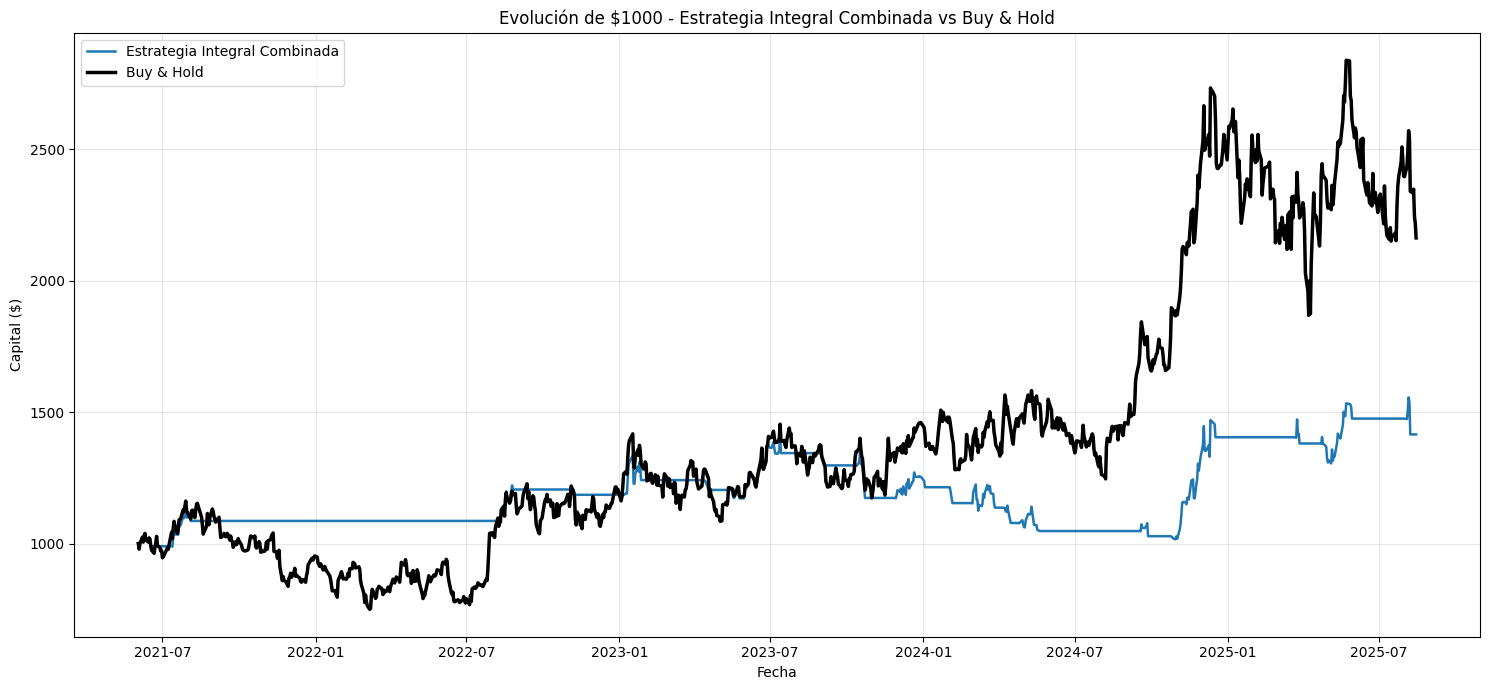


=== Métricas Comparativas: Estrategia Integral Combinada vs Buy & Hold ===


,Estrategia Integral Combinada,Buy & Hold
Capital_Inicial,1000.000000,1000.000000
Capital_Final,1414.769580,2162.059285
Retorno_Total,0.414770,1.162059
Retorno_Anualizado_Estrategia,0.086238,0.201810
Volatilidad_Estrategia,0.194346,0.425902
Sharpe_Estrategia,0.443736,0.473843
Max_Drawdown,-0.277931,-0.354244
Calmar_Ratio,0.310286,NaN
Win_Rate,0.055556,NaN
Total_Trades,108.000000,NaN


In [15]:
# ==============================================
# Backtesting de Estrategia Integral (Nueva) vs Buy & Hold
# ==============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextlib, os # Import contextlib and os

# Asegurarse de que la variable con las señales de la estrategia integral esté disponible
try:
    _ = senales_integral_combinada
except NameError:
    print("La variable 'senales_integral_combinada' no está definida. Asegúrate de ejecutar la celda anterior.")
    # Si no está definida, no podemos continuar con el backtesting de esta estrategia.
    # Podrías querer salir o cargar señales de ejemplo si es necesario.
    # Por ahora, detendremos la ejecución aquí si la variable no existe.
    raise

capital_inicial = 1000.0
comision = 0.001 # 0.1%

# Obtener los precios de cierre alineados con las señales
# Usamos el índice de las señales para asegurarnos de que los precios coincidan
precios_alineados = loma_data['Close'].squeeze().reindex(senales_integral_combinada.index).dropna()

# Realizar Backtesting de la Estrategia Integral (Suppressing output)
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    res_integral, metr_integral = backtest_estrategia(precios_alineados, senales_integral_combinada, capital_inicial=capital_inicial, comision=comision)


# Buy & Hold baseline para el mismo período
capital_bnh_alineado = 1000 * (precios_alineados / precios_alineados.iloc[0])

# Gráfico comparativo
plt.figure(figsize=(15,7))
plt.plot(res_integral.index, res_integral['Capital'], label='Estrategia Integral Combinada', linewidth=1.8)
plt.plot(capital_bnh_alineado.index, capital_bnh_alineado, label='Buy & Hold', color='black', linewidth=2.5)
plt.title('Evolución de $1000 - Estrategia Integral Combinada vs Buy & Hold')
plt.xlabel('Fecha'); plt.ylabel('Capital ($)')
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# Tabla de métricas comparativa
# Crear un diccionario para almacenar las métricas de cada estrategia
results_dict = {}

# Métricas de la Estrategia Integral Combinada
results_dict['Estrategia Integral Combinada'] = metr_integral

# Calcular métricas de Buy & Hold para la tabla (alineadas al período de la estrategia)
ret_total_bh = capital_bnh_alineado.iloc[-1] / capital_bnh_alineado.iloc[0] - 1
dias_bh = len(capital_bnh_alineado)
anios_bh = dias_bh / 252 if dias_bh > 0 else 0
ret_anual_bh = (1 + ret_total_bh)**(1/anios_bh) - 1 if anios_bh > 0 else np.nan
# Handle potential division by zero for volatility
vol_anual_bh = capital_bnh_alineado.pct_change().dropna().std() * np.sqrt(252) if dias_bh > 1 else np.nan
# Handle potential division by zero for Sharpe
sharpe_bh = ret_anual_bh / vol_anual_bh if vol_anual_bh is not None and vol_anual_bh > 0 else np.nan
mdd_bh = ((capital_bnh_alineado / capital_bnh_alineado.cummax()) - 1).min() if dias_bh > 0 else np.nan


results_dict['Buy & Hold'] = {
    'Capital_Inicial': capital_inicial,
    'Capital_Final': capital_bnh_alineado.iloc[-1] if dias_bh > 0 else capital_inicial,
    'Retorno_Total': ret_total_bh,
    'Retorno_Anualizado_Estrategia': ret_anual_bh, # Usamos el mismo nombre para la tabla comparativa
    'Volatilidad_Estrategia': vol_anual_bh,     # Usamos el mismo nombre para la tabla comparativa
    'Sharpe_Estrategia': sharpe_bh,            # Usamos el mismo nombre para la tabla comparativa
    'Max_Drawdown': mdd_bh,
    'Calmar_Ratio': np.nan, # No aplica directamente para Buy & Hold
    'Win_Rate': np.nan,     # No aplica para Buy & Hold
    'Total_Trades': np.nan, # No aplica para Buy & Hold
    'Comisiones_Totales': np.nan, # No aplica para Buy & Hold
    'Dias_Backtesting': dias_bh
}

# Convertir el diccionario de resultados a un DataFrame
tabla_comparativa_integral = pd.DataFrame(results_dict)

# Definir el orden de las métricas para la tabla
cols_order = [
    'Capital_Inicial', 'Capital_Final', 'Retorno_Total',
    'Retorno_Anualizado_Estrategia', 'Volatilidad_Estrategia', 'Sharpe_Estrategia',
    'Max_Drawdown', 'Calmar_Ratio', 'Win_Rate', 'Total_Trades', 'Comisiones_Totales',
    'Dias_Backtesting'
]

# Reordenar las columnas del DataFrame
tabla_comparativa_integral = tabla_comparativa_integral.reindex(cols_order)


print("\n=== Métricas Comparativas: Estrategia Integral Combinada vs Buy & Hold ===")
display(tabla_comparativa_integral)

###Resumen de estrategias

,Estrategia,Retorno Total,Retorno Anualizado,Volatilidad Anualizada,Sharpe Ratio,Max Drawdown,Calmar Ratio,Win Rate,Trades,Comisiones
0,Cruces SMA 50/200,0.444774,0.076618,0.333230,0.229926,-0.316503,0.242077,0.000000,7.0,7.045870
1,RSI óptimo (15),2.664152,0.297639,0.275545,1.080183,-0.260101,1.144321,0.142857,70.0,61.636592
2,Estrategia Integral,0.414770,0.086238,0.194346,0.443736,-0.277931,0.310286,0.055556,108.0,129.772797
3,Buy & Hold,2.234936,0.265604,0.437470,0.607137,-0.354244,NaN,NaN,NaN,NaN


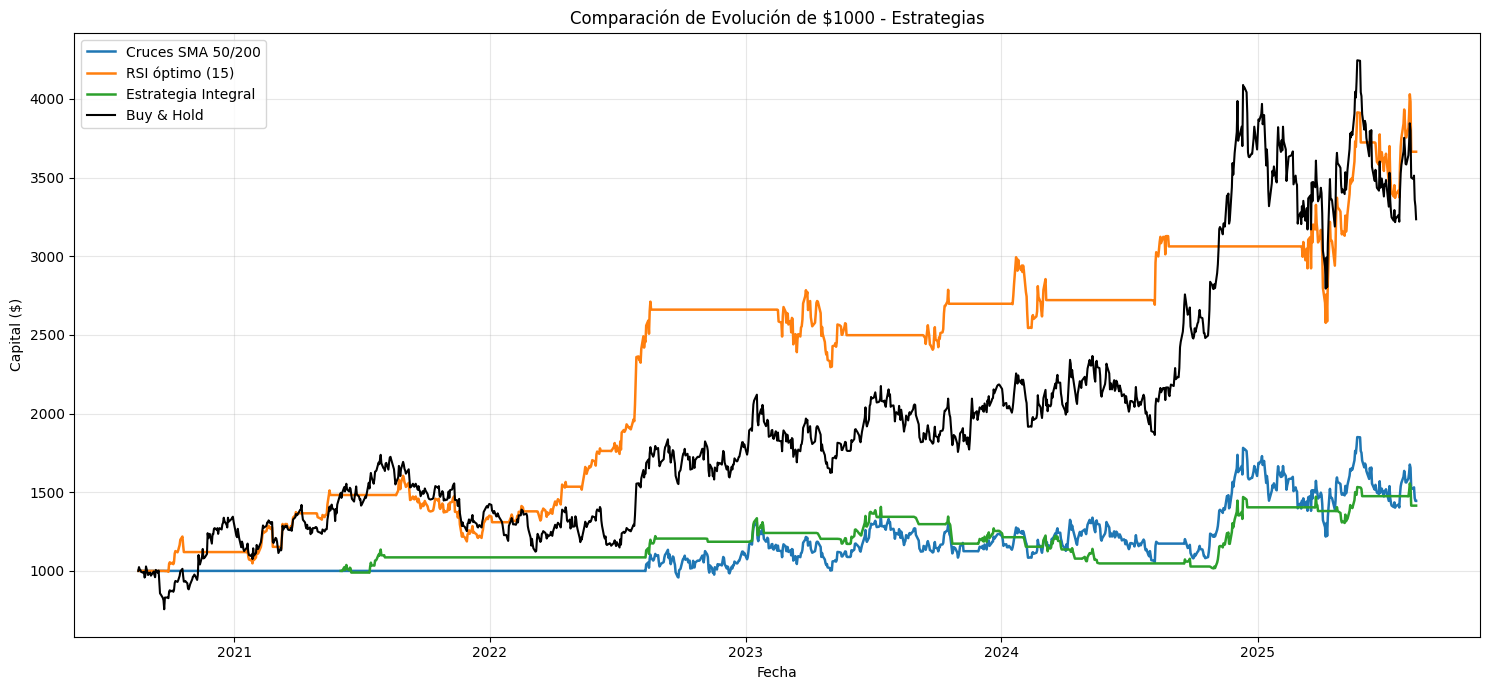

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import contextlib, os

# --- 1) Asegurar métrica/curva para RSI Óptimo (por si no quedó resguardado) ---
try:
    _ = mejor_ventana
except NameError:
    mejor_ventana = None

if (mejor_ventana is None) or (np.isnan(mejor_ventana)):
    # Si no existe, volvemos a optimizar rápido
    mejor_sharpe_tmp = -1e9
    mejor_ventana = 14
    # Suppress intermediate output during quick optimization
    with contextlib.redirect_stdout(open(os.devnull, 'w')):
        for ventana in range(7, 31):
            rsi_tmp = calcular_rsi(loma_data['Close'].squeeze(), periodo=ventana)
            señales_rsi_tmp = pd.Series(0, index=loma_data.index)
            señales_rsi_tmp[(rsi_tmp.shift(1) < 30) & (rsi_tmp >= 30)] = 1
            señales_rsi_tmp[(rsi_tmp.shift(1) > 70) & (rsi_tmp <= 70)] = -1
            _, metr_tmp = backtest_estrategia(loma_data['Close'].squeeze(), señales_rsi_tmp, capital_inicial=1000, comision=0.001)
            sharpe_tmp = metr_tmp.get('Sharpe_Estrategia', -np.inf) # Use -np.inf for comparison
            if sharpe_tmp > mejor_sharpe_tmp:
                mejor_sharpe_tmp = sharpe_tmp
                mejor_ventana = ventana

# Backtest definitivo con la mejor ventana RSI
with contextlib.redirect_stdout(open(os.devnull, 'w')):
    rsi_best = calcular_rsi(loma_data['Close'].squeeze(), periodo=int(mejor_ventana))
    señales_rsi_best = pd.Series(0, index=loma_data.index)
    señales_rsi_best[(rsi_best.shift(1) < 30) & (rsi_best >= 30)] = 1
    señales_rsi_best[(rsi_best.shift(1) > 70) & (rsi_best <= 70)] = -1
    res_rsi, met_rsi = backtest_estrategia(loma_data['Close'].squeeze(), señales_rsi_best, capital_inicial=1000, comision=0.001)


# --- 2) Buy & Hold baseline (por si no existe capital_bnh del Bloque 2) ---
try:
    _ = capital_bnh
except NameError:
    capital_bnh = 1000 * (loma_data['Close'] / loma_data['Close'].iloc[0])

# --- 3) Consolidar métricas en una tabla ---
def fila_metricas(nombre, m):
    # Use correct metric names from the backtest_estrategia output
    return {
        'Estrategia': nombre,
        'Retorno Total': m.get('Retorno_Total', np.nan),
        'Retorno Anualizado': m.get('Retorno_Anualizado_Estrategia', np.nan),
        'Volatilidad Anualizada': m.get('Volatilidad_Estrategia', np.nan),
        'Sharpe Ratio': m.get('Sharpe_Estrategia', np.nan),
        'Max Drawdown': m.get('Max_Drawdown', np.nan),
        'Calmar Ratio': m.get('Calmar_Ratio', np.nan),
        'Win Rate': m.get('Win_Rate', np.nan),
        'Trades': m.get('Total_Trades', np.nan),
        'Comisiones': m.get('Comisiones_Totales', np.nan)
    }

tabla = []
# Check if metricas and metr_integral exist before appending
if 'metricas' in locals():
    tabla.append(fila_metricas('Cruces SMA 50/200', metricas))
if 'met_rsi' in locals(): # Add RSI optimal strategy metrics
     tabla.append(fila_metricas(f'RSI óptimo ({int(mejor_ventana)})', met_rsi))
if 'metr_macd_opt' in locals(): # Add MACD optimal strategy metrics
     tabla.append(fila_metricas(f'MACD óptimo ({int(mejor["MACD_Fast"])}, {int(mejor["MACD_Slow"])}, {int(mejor["MACD_Signal"])})', metr_macd_opt))
if 'metr_adx_opt' in locals(): # Add ADX optimal strategy metrics
     tabla.append(fila_metricas(f'ADX óptimo ({int(best["ADX_Periodo"])}, umbral {int(best["ADX_Umbral"])})', metr_adx_opt))
if 'metr_integral' in locals():
    tabla.append(fila_metricas('Estrategia Integral', metr_integral))


# Add Buy & Hold metrics
# Recalculate B&H metrics to ensure consistency and inclusion in the table
cap_bh_series = capital_bnh.copy().squeeze() # Ensure it's a Series
ret_total_bh = cap_bh_series.iloc[-1] / cap_bh_series.iloc[0] - 1
anios_bh = len(cap_bh_series) / 252
ret_anual_bh = (1 + ret_total_bh)**(1/anios_bh) - 1 if anios_bh > 0 else np.nan
vol_anual_bh = cap_bh_series.pct_change().dropna().std() * np.sqrt(252)
sharpe_bh = ret_anual_bh / vol_anual_bh if vol_anual_bh > 0 else np.nan
mdd_bh = ((cap_bh_series / cap_bh_series.cummax()) - 1).min()

tabla.append({
    'Estrategia': 'Buy & Hold',
    'Retorno Total': ret_total_bh,
    'Retorno Anualizado': ret_anual_bh,
    'Volatilidad Anualizada': vol_anual_bh,
    'Sharpe Ratio': sharpe_bh,
    'Max Drawdown': mdd_bh,
    'Calmar Ratio': np.nan,
    'Win Rate': np.nan,
    'Trades': np.nan,
    'Comisiones': np.nan
})


resumen_estrategias = pd.DataFrame(tabla)
display(resumen_estrategias)

# --- 4) Gráfico comparativo de curvas de capital ---
plt.figure(figsize=(15,7))
# Check if results from strategies exist before plotting
if 'resultados' in locals():
    plt.plot(resultados.index, resultados['Capital'], label='Cruces SMA 50/200', linewidth=1.8)
if 'res_rsi' in locals():
    plt.plot(res_rsi.index, res_rsi['Capital'], label=f'RSI óptimo ({int(mejor_ventana)})', linewidth=1.8)
if 'res_integral' in locals():
    # Use res_integral which is the result of the integral strategy backtest
    plt.plot(res_integral.index, res_integral['Capital'], label='Estrategia Integral', linewidth=1.8)
# Add MACD and ADX optimal strategy results to the plot
try:
    if 'res_macd_opt' in locals():
        plt.plot(res_macd_opt.index, res_macd_opt['Capital'], label=f'MACD óptimo ({int(mejor["MACD_Fast"])},{int(mejor["MACD_Slow"])},{int(mejor["MACD_Signal"])})', linewidth=1.8)
    if 'res_adx_opt' in locals():
         plt.plot(res_adx_opt.index, res_adx_opt['Capital'], label=f'ADX óptimo ({int(best["ADX_Periodo"])}, umbral {int(best["ADX_Umbral"])})', linewidth=1.8)
except NameError:
     print("Results for MACD or ADX optimal strategies not found. Ensure optimization cells were run.")


plt.plot(capital_bnh.index, capital_bnh.squeeze(), label='Buy & Hold', color='black') # Ensure capital_bnh is a Series for plotting
plt.title('Comparación de Evolución de $1000 - Estrategias')
plt.xlabel('Fecha'); plt.ylabel('Capital ($)')
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

---
##Pregunta Crítica
¿Por qué el análisis técnico podría ser más o menos efectivo en el mercado argentino comparado con mercados desarrollados? Considerar liquidez, volatilidad e información disponible.

---

###**Efectividad del análisis técnico en Argentina vs. mercados desarrollados**

El análisis técnico puede aplicarse en ambos contextos, pero su efectividad en el mercado argentino puede verse condicionada por:

1. **Liquidez:**

   * **Mercados desarrollados:** Alta liquidez, movimientos de precios más ordenados y menor manipulación.
   * **Argentina:** Menor liquidez, spreads más amplios, volatilidad alta por bajo volumen y riesgo de manipulación. Esto puede generar más señales falsas y dificultar la ejecución de operaciones grandes.

2. **Volatilidad:**

   * **Mercados desarrollados:** Más estables, con menor frecuencia de movimientos extremos.
   * **Argentina:** Mayor volatilidad por inestabilidad económica, política y cambiaria. Esto provoca gaps frecuentes, "whipsaws" y señales extremas más comunes en indicadores como RSI o Bandas de Bollinger, lo que puede requerir ajustes en los parámetros.

3. **Información disponible:**

   * **Mercados desarrollados:** Información abundante, estandarizada y oportuna, con alta cobertura de analistas.
   * **Argentina:** Información menos estandarizada, a veces tardía, y fuerte impacto de noticias políticas/económicas. Esto aumenta el “ruido” en el precio y puede dificultar la lectura técnica.

**Conclusión:**
El análisis técnico sigue siendo útil en Argentina, pero requiere **adaptaciones**:

* Ajustar parámetros de indicadores al nivel de volatilidad local.
* Usar stops y objetivos más amplios.
* Priorizar marcos temporales más largos.
* Complementar con análisis fundamental y macroeconómico.
* Considerar la liquidez antes de operar.

En síntesis, el marco técnico es universal, pero su interpretación debe adaptarse a las características estructurales del mercado argentino.
